## Notebook used for analysis of morphological fingerprints and differential morphology features - related to Fig 4, S5

In [14]:
# analyze features
import scanpy as sc
import pandas as pd
import seaborn as sns
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import numpy as np
import os
import sys
import glob
from imageio import volread as imread
from skimage.filters import threshold_otsu

from skimage import measure
from scipy import stats
import umap
from sklearn.decomposition import PCA
import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

import dcor
import pickle
from scipy.spatial.distance import euclidean

# import utility function
import image_analysis_utils as utils

import networkx as nx

from scipy.stats import ks_2samp
import statsmodels.stats.multitest as smm

from sklearn.metrics.pairwise import cosine_similarity

# define directory
ADATA_DIR = '../adata_integrated/adata_Cellpose_Subset_All_Channels_011425.h5ad'
RESULT_DIR = '../Fig4_Results'

In [15]:
utils.test()

test


## Gene-gene similarity analysis

In [16]:
# reload
adata = sc.read(ADATA_DIR)
adata

AnnData object with n_obs × n_vars = 156636 × 2827
    obs: 'FileName_Nuclei', 'FileName_Soma', 'FileName_max', 'PathName_Nuclei', 'PathName_Soma', 'PathName_max', 'Children_Cytoplasm_Count', 'Location_CenterMassIntensity_X_AGP', 'Location_CenterMassIntensity_X_DNA', 'Location_CenterMassIntensity_X_ER', 'Location_CenterMassIntensity_X_G3BP1', 'Location_CenterMassIntensity_X_GFAP', 'Location_CenterMassIntensity_X_GM130', 'Location_CenterMassIntensity_X_Golgin97', 'Location_CenterMassIntensity_X_LAMP1', 'Location_CenterMassIntensity_X_NFKB', 'Location_CenterMassIntensity_X_NeuN', 'Location_CenterMassIntensity_X_RANGAP1', 'Location_CenterMassIntensity_X_SYTO', 'Location_CenterMassIntensity_X_TDP43', 'Location_CenterMassIntensity_X_TOM20', 'Location_CenterMassIntensity_X_fourHNE', 'Location_CenterMassIntensity_X_pRPS6', 'Location_CenterMassIntensity_Y_AGP', 'Location_CenterMassIntensity_Y_DNA', 'Location_CenterMassIntensity_Y_ER', 'Location_CenterMassIntensity_Y_G3BP1', 'Location_CenterMas

In [61]:
# subset to repeat classification;
adata = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]

In [62]:
adata[(adata.obs.Sample == 'Coverslip4')&(adata.obs.Gene == 'non-target')].X.mean(axis=0)

ArrayView([-1.5283242e-09,  2.5599430e-08, -1.5283242e-09, ...,
            4.3666408e-09,  8.2966176e-09,  8.7332813e-10], dtype=float32)

In [63]:
# perform PCA, umap and leiden 
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 15)
sc.tl.umap(adata, random_state = 0)
sc.tl.leiden(adata, resolution = 1, key_added = 'leiden_1')
sc.tl.leiden(adata, resolution = 0.75, key_added = 'leiden_0.75')
sc.tl.leiden(adata, resolution = 0.5, key_added = 'leiden_0.5')

In [64]:
## Pairwise Binary classification

genes = set(adata.obs.Gene)
pairwise_clf_results_auc = {} 
clf_df = pd.DataFrame(index = list(genes), columns = list(genes))
    # subset adata
#adata_sub = adata[(adata.obs.Time == time)&(adata.obs.Media == media)]
    

# navigating through pairwise datafrmae.
for i in range(len(clf_df.columns)):
    for j in range(i+1, len(clf_df.columns)):

        geneA = clf_df.columns[i]
        geneB = clf_df.columns[j] 
            
            # call the helper function
        auc = utils.pairwise_binary_clf(adata, geneA, geneB, True)
        clf_df.loc[clf_df.columns[i], clf_df.columns[j]] = auc
            
# fill in the empty values
for i in range(len(clf_df.columns)):
    for j in range(i+1, len(clf_df.columns)):
        clf_df.loc[clf_df.columns[j], clf_df.columns[i]] = clf_df.loc[clf_df.columns[i], clf_df.columns[j]]
    
for i in range(len(clf_df.columns)):
    clf_df.loc[clf_df.columns[i], clf_df.columns[i]] = 1.0
    
# save final dataframe into master dictionary
pairwise_clf_results_auc['D10_STD'] = clf_df

/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


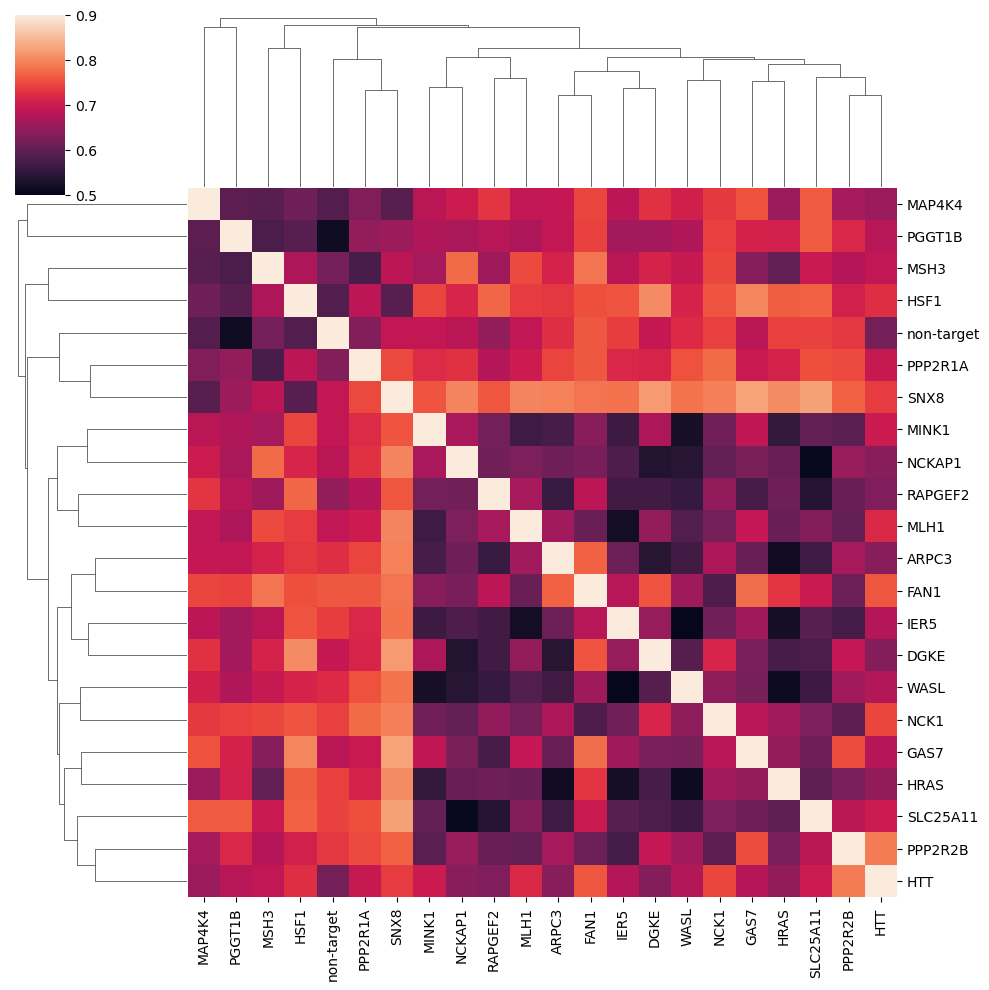

In [22]:
df = pairwise_clf_results_auc['D10_STD'].copy().astype('float')

sns.clustermap(df, vmin= 0.5, vmax=0.9, cmap ='rocket', metric = 'correlation')

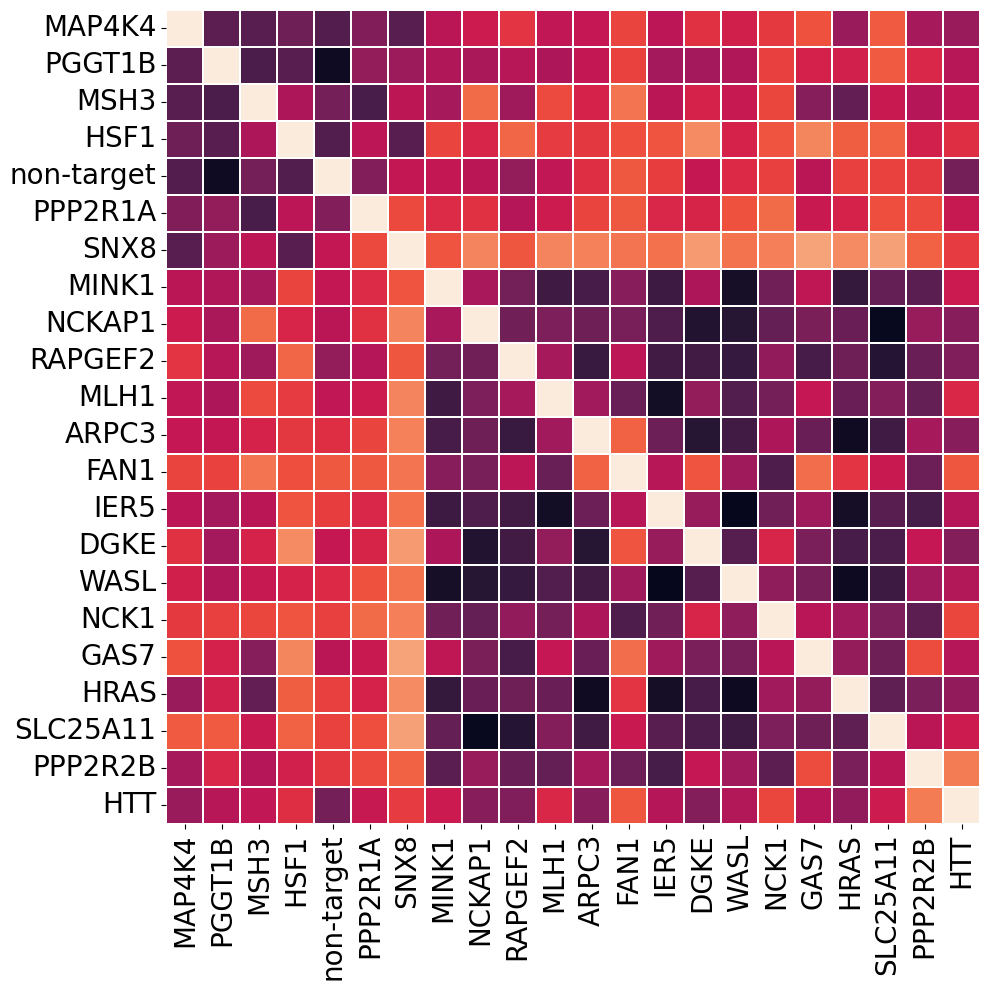

In [24]:

# removing DGKE and GAS7
gene_order = ['MAP4K4', 'PGGT1B', 'MSH3', 'HSF1', 'non-target', 'PPP2R1A', 'SNX8', 'MINK1', 
 'NCKAP1', 'RAPGEF2', 'MLH1', 'ARPC3', 'FAN1', 'IER5', 'DGKE', 'WASL', 'NCK1', 
 'GAS7', 'HRAS', 'SLC25A11', 'PPP2R2B', 'HTT']



fig, axs = plt.subplots(1,1, figsize=(10, 10))
cond = 'D10_STD'

# Extract and process the data for the current condition
df = pairwise_clf_results_auc['D10_STD'].copy().astype('float')
df = df.loc[gene_order, gene_order]

# Plot heatmap on the respective axis
sns.heatmap(df, vmin=0.5, vmax=0.9, cmap='rocket', ax=axs, linewidth = 0.05, cbar=False,
           cbar_kws={'shrink': 0.8, 'ticks': [0.5, 0.6, 0.7, 0.8, 0.9]})  # Corrected "ax" instead of "axs"
axs.tick_params(axis='both', labelsize=20)
#cbar = axs.collections[0].colorbar
#cbar.ax.tick_params(labelsize=25)  # Set colorbar tick label size

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_Heatmap_auc_distance.png', format='png', dpi = 300)    
plt.savefig('../Figures_Fig4/D10_STD_Heatmap_auc_distance.eps', format='eps', dpi = 300)

In [70]:
# save results
adata.write('../adata_integrated/D10_STD_adata.h5ad')

with open(f'{RESULT_DIR}/pairwise_clf_results_auc.pkl', 'wb') as handle:
    pickle.dump(pairwise_clf_results_auc, handle)

In [20]:
with open(f'{RESULT_DIR}/pairwise_clf_results_auc.pkl', 'rb') as handle:
    pairwise_clf_results_auc = pickle.load(handle)

In [21]:
pairwise_clf_results_auc.keys()

dict_keys(['D10_STD'])

## compare with ppi

In [5]:
# load clf_results
# reload
ADATA_DIR = '../adata_integrated/D10_STD_adata.h5ad'
adata = sc.read(ADATA_DIR)
print(adata.shape)
with open(f'{RESULT_DIR}/pairwise_clf_results_auc.pkl', 'rb') as handle:
    pairwise_clf_results_auc=pickle.load(handle)  

(23221, 2827)


In [6]:
# determine threshold- within non-targets, randomly split and classify. 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report

permuted_clf_results = {}
conditions = ['STD']
for cond in conditions:
    adata_subset = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == cond)&(adata.obs.Gene == 'non-target')]
    print(adata_subset.shape)
    L = []
    for i in range(1000): # 1000 randomizations
        num_rows = adata_subset.shape[0]
        half = num_rows // 2
        # Generate a list with half 1's and half 0's, then shuffle
        labels = [1] * half + [0] * (num_rows - half)
        np.random.shuffle(labels)
        
        adata_subset.obs['Permuted_Label'] = labels
        
        # classify
        X = adata_subset.obsm['X_pca']
        y = adata_subset.obs.Permuted_Label
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i)
        model = LogisticRegression(solver='saga', max_iter = 1000, class_weight = 'balanced',
                                random_state = 0) # account for class imbalance
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test.values, y_pred) 
        #print(auc)
        L.append(auc)
    # update dictionary 
    permuted_clf_results[cond] = L

(627, 2827)


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_5361/1929141874.py:20: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_subset.obs['Permuted_Label'] = labels


0.6711460446247465
0.34252466481153554
0.6229822515212982


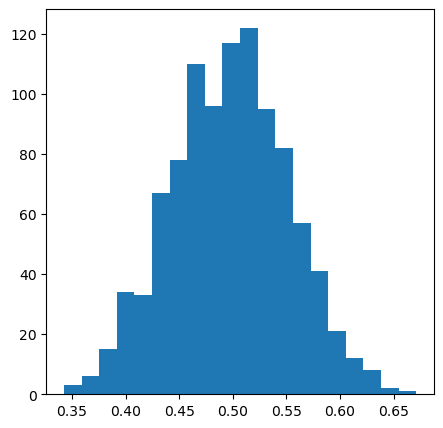

In [7]:
# plot results
fig, axs = plt.subplots(1,1, figsize = (5,5))
conditions = ['STD']
for i in range(1):
    cond = conditions[i]
    axs.hist(permuted_clf_results[cond], bins = 20);
    print(max(permuted_clf_results[cond]))
    print(min(permuted_clf_results[cond]))
    print(np.quantile(permuted_clf_results[cond], 0.99))

In [10]:
print(np.mean(permuted_clf_results[cond]))
print(np.quantile(permuted_clf_results[cond], 0.999))

0.49757642160087867
0.6429213980607531


In [76]:
# assess similarity vs ppi
# load network
G_ppi = nx.read_graphml('../network_input/lv_cluster_10.graphml')
# this network contains 32 nodes. Subset into graph only containing measured nodes.
genes = set(adata.obs.Gene)

all_nodes = list(G_ppi.nodes())
to_remove = [x for x in all_nodes if x not in genes]
print(all_nodes)
print(to_remove)

G_ppi.remove_nodes_from(to_remove)

print(G_ppi.nodes())

['HRAS', 'ARPC3', 'MAN2A1', 'ERBB3', 'SNX8', 'SNAP91', 'FLOT1', 'RASA1', 'DAB1', 'HYAL3', 'C17orf67', 'PRKCI', 'SVIL', 'FAN1', 'GAS7', 'MSH3', 'HSF1', 'PPP2R2B', 'NCK1', 'SLC25A11', 'WASL', 'RAPGEF2', 'GOPC', 'DGKE', 'ROS1', 'CLTB', 'NCKAP1', 'PTPN11', 'MLH1', 'IER5', 'MINK1', 'MAP4K4']
['MAN2A1', 'ERBB3', 'SNAP91', 'FLOT1', 'RASA1', 'DAB1', 'HYAL3', 'C17orf67', 'PRKCI', 'SVIL', 'GOPC', 'ROS1', 'CLTB', 'PTPN11']
['HRAS', 'ARPC3', 'SNX8', 'FAN1', 'GAS7', 'MSH3', 'HSF1', 'PPP2R2B', 'NCK1', 'SLC25A11', 'WASL', 'RAPGEF2', 'DGKE', 'NCKAP1', 'MLH1', 'IER5', 'MINK1', 'MAP4K4']


In [77]:
# Test 1) AUC vs PPI --> keep PPI same, permute AUC
J_list = []
for seed in range(10000):
    df = pairwise_clf_results_auc['D10_STD'].copy()
    shuffled_df = utils.permute_auc_dataframe(df, seed)
    nodes = list(G_ppi.nodes()) # **ensures that the auc graph is also consistently labelled with ppi graph.
    thres = 0.65
    G2 = utils.create_networkx_from_auc(shuffled_df, thres, nodes)
    J = utils.jaccard_index_edges(G_ppi, G2)
    J_list.append(J)

# J_observed 
G2 = utils.create_networkx_from_auc(df, thres, nodes)
J_observed = utils.jaccard_index_edges(G_ppi, G2)
print(J_observed)

pval = len([x for x in J_list if x>J_observed])/10000 # probability that permuted J is greater than observed
print(pval)

0.2
0.0273


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


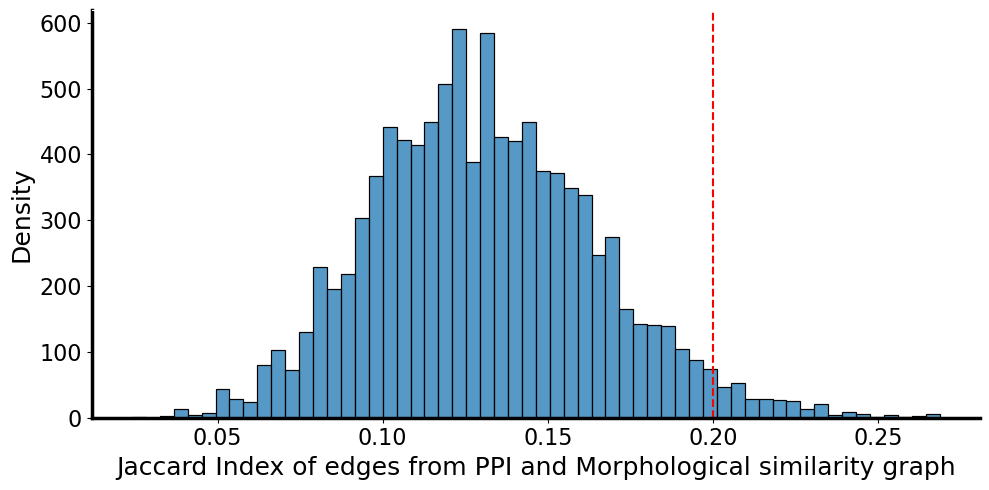

In [78]:
# plot results
fig, axs = plt.subplots(1,1, figsize = (10,5))
sns.histplot(J_list, kde=False, ax=axs)
axs.set_xlabel('Jaccard Index of edges from PPI and Morphological similarity graph', fontsize=18) # Adjust fontsize as needed
axs.set_ylabel('Density', fontsize=18) # Adjust fontsize as needed
axs.tick_params(axis='both', which='major', labelsize=16)
axs.spines['bottom'].set_color('black')
axs.spines['left'].set_color('black')
axs.spines['top'].set_color('white')
axs.spines['right'].set_color('white')
axs.spines['bottom'].set_linewidth(2.5)
axs.spines['left'].set_linewidth(2.5)
# Draw a horizontal line at x=0.20
axs.axvline(x=J_observed, color='red', linestyle='--') # You can customize color and linestyle
axs.set_facecolor('white')
axs.grid(False)
# Show the plot
plt.tight_layout()
plt.savefig('../Figures_Fig4/AUC_vs_PPI_D10_STD.png', format='png', dpi = 300)    
plt.savefig('../Figures_Fig4/AUC_vs_PPI_D10_STD.eps', format='eps', dpi = 300)

## Compare with cell painting

In [88]:
adata1 = adata[(adata.obs.Time == "D10") &(adata.obs.Media == 'STD')]

print(adata1.shape)

(23221, 2827)


In [89]:
# define feature subgroup - to separate between "Cell Painting Dyes" and Antibody
cellpaint = ['DNA','SYTO','ER','AGP','TOM20']
noncellpaint = ['G3BP1','LAMP1','RANGAP1','TDP43','pRPS6']

# subset feature groups 
cp_feats = []; noncp_feats = []; misc_feats = []; corr_feats = []
for feat in adata1.var_names:
    if feat.split('_')[0] == 'Correlation':
        # Correlation_feat1_feat2 means channel 1 vs 2 correlation. 
        # we want to exclude CellPainting vs Antibody Correlation features for this analysis purpose.
        feat1 = feat.split('_')[2]
        feat2 = feat.split('_')[3]
        # if cellpainting vs cell painting correlation, then include in cell painting subset
        if (feat1 in cellpaint)&(feat2 in cellpaint): 
            cp_feats.append(feat)
        elif (feat1 in noncellpaint)&(feat2 in noncellpaint): # if antibody vs antibody, then include in non-cp
            noncp_feats.append(feat)
        elif (feat1 in cellpaint)&(feat2 in noncellpaint): # if cross-talk (antibody vs cellpainting) then set aside
            corr_feats.append(feat)
        elif (feat1 in noncellpaint)&(feat2 in cellpaint):
            corr_feats.append(feat)
    # if area related or neighbor related, then include in either for fair comparisons. 
    elif (feat.split('_')[0] == 'AreaShape')|(feat.split('_')[0] == 'Neighbors'):
        cp_feats.append(feat)
        noncp_feats.append(feat)
        misc_feats.append(feat)
    # otherwise if any other features include one of the channel names 
    elif len(set(feat.split('_')).intersection(set(cellpaint)))>0:
        cp_feats.append(feat)
    elif len(set(feat.split('_')).intersection(set(noncellpaint)))>0:
        noncp_feats.append(feat)
        
print(len(cp_feats)) # cell painting features
print(len(noncp_feats)) # non-cell painting features
print(len(misc_feats)) # unrelated, neighbor features
print(len(corr_feats)) # correlation 

1095
975
105
150


In [90]:
# subset adata by feature groups
adata1_cp = adata1[:,adata1.var_names.isin(cp_feats)] # cell painting D28_STD
adata1_noncp = adata1[:,adata1.var_names.isin(noncp_feats)] # antibody D28_STD

print(adata1_cp.shape)
print(adata1_noncp.shape)

(23221, 1095)
(23221, 975)


In [91]:
# because we scaled "each" feature separately, and for each sample separately, no need to scale from raw
# perform PCA again for each data subset
sc.tl.pca(adata1_cp, random_state = 0)
sc.tl.pca(adata1_noncp, random_state = 0)

In [92]:
# classification
genes = list(set(adata1.obs.Gene))
genes.remove('DGKE')
genes.remove('GAS7')
genes.remove('non-target')
print(len(genes))
cp_vs_all_D10_STD = pd.DataFrame(index = genes, columns = ['CP', 'All'])


for gene in genes:
    cp_vs_all_D10_STD.loc[gene, 'CP'] = utils.pairwise_binary_clf(adata1_cp, gene, 'non-target', True)
    cp_vs_all_D10_STD.loc[gene, 'All'] = utils.pairwise_binary_clf(adata1, gene, 'non-target', True)

19


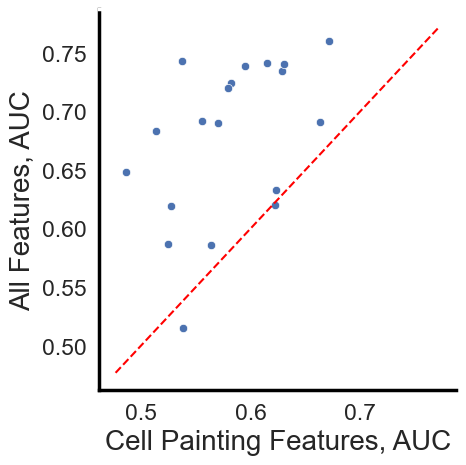

In [126]:
# plot results
fig,axs = plt.subplots(1,1, figsize = (5,5))
sns.set(font_scale = 1.5)
sns.scatterplot(data=cp_vs_all_D10_STD, x='CP', y = 'All', ax=axs)


x_vals = axs.get_xlim()
y_vals = axs.get_ylim()
axs.set_facecolor('white')
min_val = min(x_vals[0], y_vals[0])
max_val = max(x_vals[1], y_vals[1])
axs.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
axs.spines['bottom'].set_color('black')
axs.spines['left'].set_color('black')
axs.spines['right'].set_visible('False')
axs.spines['top'].set_visible('False')
for spine in axs.spines.values():
    spine.set_linewidth(2.5)
    
axs.set_xlabel('Cell Painting Features, AUC', fontsize = 20)
axs.set_ylabel('All Features, AUC', fontsize = 20)
    #axs[i].set_title(titles[i], fontsize = 25)
    
    
plt.tight_layout()
plt.savefig('../Figures_Fig4/Antibody_vs_Dyes_D10_STD.png', format='png', dpi = 300)    
plt.savefig('../Figures_Fig4/Antibody_vs_Dyes_D10_STD.eps', format='eps', dpi = 300)

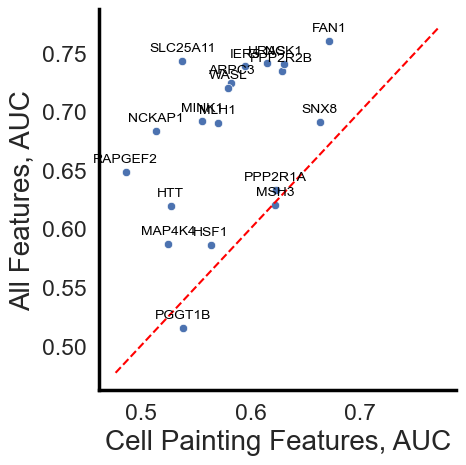

In [297]:
# Plot results
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
sns.set(font_scale=1.5)
sns.scatterplot(data=cp_vs_all_D10_STD, x='CP', y='All', ax=axs)

# Annotate each dot with its index, slightly above the dot
for i, row in cp_vs_all_D10_STD.iterrows():
    axs.annotate(
        i,  # Index name
        (row['CP'], row['All']),  # Original coordinates
        xytext=(0, 5),  # Offset annotation slightly above the dot
        textcoords='offset points',
        fontsize=10,  # Font size for annotation
        color='black',  # Annotation text color
        ha='center',  # Center-align annotation horizontally
        va='bottom'  # Place annotation above the dot
    )

# Plot identity line
x_vals = axs.get_xlim()
y_vals = axs.get_ylim()
axs.set_facecolor('white')
min_val = min(x_vals[0], y_vals[0])
max_val = max(x_vals[1], y_vals[1])
axs.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Customize spines
axs.spines['bottom'].set_color('black')
axs.spines['left'].set_color('black')
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
for spine in axs.spines.values():
    spine.set_linewidth(2.5)

# Set labels
axs.set_xlabel('Cell Painting Features, AUC', fontsize=20)
axs.set_ylabel('All Features, AUC', fontsize=20)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('../Figures_Fig4/Antibody_vs_Dyes_D10_STD.png', format='png', dpi=300)
plt.savefig('../Figures_Fig4/Antibody_vs_Dyes_D10_STD.eps', format='eps', dpi=300)
plt.show()


In [95]:
print(np.mean(cp_vs_all_D10_STD['CP']), np.mean(cp_vs_all_D10_STD['All']))

df = pd.concat([cp_vs_all_D10_STD], axis = 0)
print(np.mean(df['CP']), np.mean(df['All']))

0.5803938759051458 0.6770650481684442
0.5803938759051458 0.6770650481684442


In [96]:
# D28 results
# Pairwise Logistic Regression Classifier.

clf_results_D10 = {}

genes = set(adata.obs.Gene)
#genes.remove('DGKE') # remove outlier sample with low cell count
#genes.remove('GAS7') 
conditions = ['Coverslip1','Coverslip4']

for key in conditions:
    clf_df = pd.DataFrame(index = list(genes), columns = list(genes))
    print(key)
    for i in range(len(clf_df.columns)):
        for j in range(i+1, len(clf_df.columns)):
            geneA = clf_df.columns[i]
            geneB = clf_df.columns[j] 
            X = adata[(adata.obs.Sample == key)&(adata.obs.Gene.isin([geneA, geneB]))].obsm['X_pca']
            y = adata[(adata.obs.Sample == key)&(adata.obs.Gene.isin([geneA, geneB]))].obs.Gene
            X_train, X_test, y_train, y_test = utils.train_test_split(X, y, test_size = 0.2, random_state = 0)
            model = utils.LogisticRegression(solver='saga', max_iter = 1000, class_weight = 'balanced',
                                      random_state = 0) # account for class imbalance
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)[:,1]
            auc = utils.roc_auc_score(y_test.values, y_pred) 
            #print(geneA, geneB, auc)
            clf_df.loc[clf_df.columns[i], clf_df.columns[j]] = auc
            

    # fill in the empty values
    for i in range(len(clf_df.columns)):
        for j in range(i+1, len(clf_df.columns)):
            clf_df.loc[clf_df.columns[j], clf_df.columns[i]] = clf_df.loc[clf_df.columns[i], clf_df.columns[j]]
                
    for i in range(len(clf_df.columns)):
        clf_df.loc[clf_df.columns[i], clf_df.columns[i]] = 1.0
    
    #pairwise_clf_results_f1[key] = clf_df
    clf_results_D10[key] = clf_df

Coverslip1


/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Coverslip4


/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/bkang/mambaforge/envs/imlab2/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

In [97]:
# assess rep-rep correlation
genes = clf_results_D10['Coverslip1'].columns

# generate geneA_geneB index
index_combinations = []
for i in range(len(genes)):
    for j in range(i+1, len(genes)):
        index_combinations.append(genes[i]+'_'+genes[j])
# initialize

corr_df = pd.DataFrame(index=index_combinations, columns=['Coverslip1', 'Coverslip4'])
# D10_STD
for i in range(len(genes)):
    for j in range(i+1, len(genes)):
        geneA = clf_results_D10['Coverslip1'].columns[i]
        geneB = clf_results_D10['Coverslip1'].columns[j] 
        corr_df.loc[genes[i]+'_'+genes[j]]['Coverslip1'] = clf_results_D10['Coverslip1'].loc[geneA, geneB]
        corr_df.loc[genes[i]+'_'+genes[j]]['Coverslip4'] = clf_results_D10['Coverslip4'].loc[geneA, geneB]

# D10_AO
#for i in range(len(genes)):
#    for j in range(i+1, len(genes)):
#        geneA = clf_results_D10['Coverslip1'].columns[i]
#        geneB = clf_results_D10['Coverslip1'].columns[j] 
#        corr_df.loc[genes[i]+'_'+genes[j]]['Coverslip1'] = clf_results_D10['Coverslip1'].loc[geneA, geneB]
#        corr_df.loc[genes[i]+'_'+genes[j]]['Coverslip4'] = clf_results_D10['Coverslip4'].loc[geneA, geneB]
corr_df

Coverslip1 Coverslip4
ARPC3_FAN1         0.688381   0.736627
ARPC3_IER5         0.593023   0.632831
ARPC3_RAPGEF2      0.532959   0.516048
ARPC3_DGKE         0.623932   0.523684
ARPC3_non-target   0.704064    0.63387
...                     ...        ...
HRAS_PGGT1B        0.727149    0.67598
HRAS_SNX8           0.78172   0.797285
HSF1_PGGT1B        0.622081   0.648789
HSF1_SNX8          0.540496   0.616027
PGGT1B_SNX8        0.633061   0.701241

[231 rows x 2 columns]

Coverslip1 Coverslip4


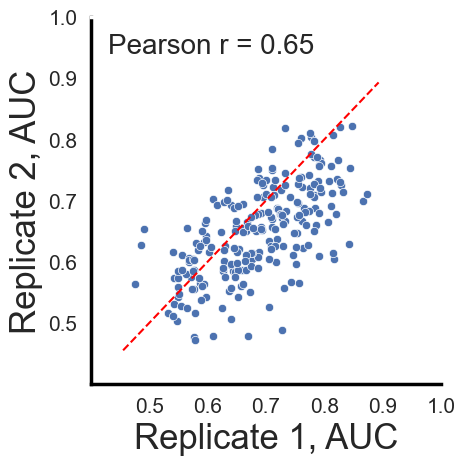

In [98]:
# generate replicate-replicate plot; each dot is geneA-geneB classification accuracy in particular replicate.
fig, ax = plt.subplots(1,1, figsize= (5,5))
sns.scatterplot(data=corr_df, x='Coverslip1', y = 'Coverslip4', ax=ax)
#sns.scatterplot(data=corr_df, x='Coverslip15', y = 'Coverslip18', ax=axs[2])

tick_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

sample1 = 'Coverslip1'
sample2 = 'Coverslip4'
print(sample1,sample2)
x_vals = ax.get_xlim()
y_vals = ax.get_ylim()
    
ax.set_xlim(0.4, 1.0)
ax.set_ylim(0.4, 1.0)
ax.set_xticks(tick_values)
ax.set_yticks(tick_values)
    
ax.set_facecolor('white')

ax.set_xlabel('Replicate 1, AUC',fontsize=25)
ax.set_ylabel('Replicate 2, AUC',fontsize=25)
ax.tick_params(axis='both', labelsize = 15)
min_val = min(x_vals[0], y_vals[0])
max_val = max(x_vals[1], y_vals[1])
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
    
ax.spines['top'].set_visible('False')
ax.spines['right'].set_visible('False')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
corr_coef, _ = utils.pearsonr(corr_df[sample1], corr_df[sample2])
ax.text(0.05, 0.9, f'Pearson r = {corr_coef:.2f}', transform=ax.transAxes, fontsize=20)
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_replicate_replicate_correlation.png', format='png', dpi = 300)    
plt.savefig('../Figures_Fig4/D10_replicate_replicate_correlation.eps', format='eps', dpi = 300)

## Differential feature analysis

In [99]:
# initialize
ks_results_store = {}
conditions = ['D10_STD']
for cond in conditions:
    ks_results_store[cond] = {} 
    
    
for cond in conditions:
    for gene in set(adata.obs.Gene):
        time = cond.split('_')[0]
        media = cond.split('_')[1]
        if gene != 'non-target':
            adata1 = adata[(adata.obs.Gene == 'non-target')&(adata.obs.Time == time)&(adata.obs.Media == media)]
            adata2 = adata[(adata.obs.Gene == gene)&(adata.obs.Time == time)&(adata.obs.Media == media)]
        
            # initialize
            ks_df = pd.DataFrame(index = adata.var.index, columns = ['p_val','stat', 'p_adj'])
            for feat in adata1.var_names:
                array1 = adata1[:, feat].X.reshape(-1)
                array2 = adata2[:, feat].X.reshape(-1)
                stat, p_value = ks_2samp(array1, array2)
                ks_df.loc[feat, 'p_val'] = p_value
                ks_df.loc[feat, 'stat'] = stat
            ks_df['p_adj'] = smm.multipletests(ks_df['p_val'], method = 'fdr_bh')[1]
            #######
            ks_results_store[cond][gene] = ks_df.copy()
            
# append median Z and mean Z value for each gene
for cond in conditions:
    for gene in ks_results_store[cond].keys():
        time = cond.split('_')[0]
        media = cond.split('_')[1]
        array = adata[(adata.obs.Gene == gene)&(adata.obs.Time == time)&(adata.obs.Media==media)].X
        ks_df = ks_results_store[cond][gene]
        ks_df['Median_Z'] = np.median(array, axis = 0)
        ks_df['Mean_Z'] = np.array(np.mean(array, axis = 0))
        ks_results_store[cond][gene] = ks_df.copy()
ks_results_store[cond][gene]            

p_val      stat     p_adj  Median_Z  \
AreaShape_CentralMoment_0_1      0.005761  0.076889  0.008296  0.021843   
AreaShape_CentralMoment_0_2           0.0  0.177966       0.0 -0.427957   
AreaShape_CentralMoment_0_3      0.002498  0.082218  0.003774  0.053668   
AreaShape_CentralMoment_1_0      0.015768  0.069928  0.021597 -0.062114   
AreaShape_CentralMoment_1_1      0.002827  0.081451  0.004244  0.052068   
...                                   ...       ...       ...       ...   
Texture_Variance_pRPS6_3_03_256       0.0  0.156501       0.0 -0.564856   
Texture_Variance_pRPS6_5_00_256       0.0  0.154065       0.0 -0.559689   
Texture_Variance_pRPS6_5_01_256       0.0  0.153407       0.0 -0.559494   
Texture_Variance_pRPS6_5_02_256       0.0   0.15291       0.0 -0.564458   
Texture_Variance_pRPS6_5_03_256       0.0  0.151965       0.0 -0.563243   

                                   Mean_Z  
AreaShape_CentralMoment_0_1      0.024920  
AreaShape_CentralMoment_0_2     -0.279539  
AreaShape_CentralMoment_0_3      0.028954  
AreaShape_CentralMoment_1_0     -0.075246  
AreaShape_CentralMoment_1_1     -0.013505  
...                                   ...  
Texture_Variance_pRPS6_3_03_256 -0.162589  
Texture_Variance_pRPS6_5_00_256 -0.163075  
Texture_Variance_pRPS6_5_01_256 -0.159442  
Texture_Variance_pRPS6_5_02_256 -0.160860  
Texture_Variance_pRPS6_5_03_256 -0.161060  

[2827 rows x 5 columns]

In [100]:
import numbers
def get_qq_rsquared(x, y, remove_quantiles = None, quantiles=None, interpolation='linear'):
    if remove_quantiles is not None:
        # remove 1 and 100-th quantile from both x and y to mitigate effect of outliers; 
        x= x[(x>=np.quantile(x, 0.01)) & (x <= np.quantile(x, 0.99))]
        y = y[(y>=np.quantile(y, 0.01)) & (y <= np.quantile(y, 0.99))]
        
    
    
    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)
    # calculate R2
    residuals = y_quantiles - x_quantiles # observed - expected 
    ss_total = np.sum((y_quantiles - np.mean(y_quantiles))**2)
    ss_residual = np.sum(residuals**2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [101]:
# quantify r_squared for all features, for all genes
for cond in conditions:
    time = cond.split('_')[0]
    media = cond.split('_')[1]
    for gene in ks_results_store[cond].keys():
        data = adata[(adata.obs.Time == time)&(adata.obs.Media == media)]
        df = ks_results_store[cond][gene]
    
        print(gene)
    
        # initialize
        df['R2_QQplot'] = 0 
        for feat in df.index:
            data1 = data[data.obs.Gene == 'non-target', feat].X.flatten()
            data2 = data[data.obs.Gene == gene, feat].X.flatten()
            
            r2_test = get_qq_rsquared(data1, data2, quantiles=100, interpolation='linear')
            df.loc[feat, 'R2_QQplot'] = r2_test
        ks_results_store[cond][gene] = df.copy()
    # do the same for all dataset. 


ARPC3


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


FAN1


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


IER5


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


RAPGEF2


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


DGKE


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


MINK1


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


MAP4K4


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


MLH1


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


MSH3


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


GAS7


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


NCKAP1


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


PPP2R1A


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


PPP2R2B


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


HTT


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


WASL


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


SLC25A11


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


NCK1


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


HRAS


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


HSF1


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


PGGT1B


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


SNX8


/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:18: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
/var/folders/s7/fg8686z944s5332vtll29z5h0000gn/T/ipykernel_36711/3755094856.py:19: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)


In [102]:
# 
for cond in conditions:
    for gene in ks_results_store[cond].keys():
        ks_df = ks_results_store[cond][gene]
        ks_df['-log10(FDR)'] = -np.log10(ks_df['p_adj'].astype('float32'))
        ks_results_store[cond][gene] = ks_df

In [103]:
print(RESULT_DIR)

../Fig4_Results


In [104]:
# save results

with open(f'{RESULT_DIR}/ks_results_store', 'wb') as f:
    pickle.dump(ks_results_store, f)

In [110]:
RESULT_DIR

'../Fig4_Results'

## Compare with Codebook

In [111]:
# Perform Pairwise Cosine Similarity Calculation for each Condition separately. 
features = [f'intensity_mean-{x}' for x in range(6)]
cos_procode_dfs = {}
labels = ['D10_STD']
for key in labels:
    genes = list(set(adata.obs.Gene))
    #genes.remove('DGKE')
    #genes.remove('GAS7')
    print(genes)
    cosine_dist_df = pd.DataFrame(index = genes, columns = genes)
    time = key.split('_')[0]
    media = key.split('_')[1]
    print(time, media)
    for geneA in genes:
        for geneB in genes:
            A = adata[(adata.obs.Gene == geneA)&(adata.obs.Time == time)&(adata.obs.Media == media)].obs[features].values
            B = adata[(adata.obs.Gene == geneB)&(adata.obs.Time == time)&(adata.obs.Media == media)].obs[features].values
            
            dist = cosine_similarity(np.mean(A, axis=0, keepdims = True),np.mean(B, axis=0, keepdims=True))
            cosine_dist_df.loc[geneA, geneB] = dist.reshape(-1)[0]
    cos_procode_dfs[key] = cosine_dist_df.copy()

['ARPC3', 'FAN1', 'IER5', 'RAPGEF2', 'DGKE', 'non-target', 'MINK1', 'MAP4K4', 'MLH1', 'MSH3', 'GAS7', 'NCKAP1', 'PPP2R1A', 'PPP2R2B', 'HTT', 'WASL', 'SLC25A11', 'NCK1', 'HRAS', 'HSF1', 'PGGT1B', 'SNX8']
D10 STD


PGGT1B  MAP4K4  NCK1  HSF1  MINK1  IER5  SNX8  non-target  PPP2R2B  \
NWS       1.0     0.0   1.0   0.0    0.0   0.0   0.0         1.0      0.0   
VSVG      1.0     0.0   1.0   0.0    1.0   0.0   0.0         0.0      0.0   
FLAG      1.0     1.0   0.0   0.0    1.0   0.0   1.0         0.0      1.0   
HSV       0.0     0.0   0.0   1.0    0.0   1.0   1.0         1.0      1.0   
C         0.0     1.0   1.0   0.0    1.0   1.0   0.0         0.0      0.0   
S         0.0     1.0   0.0   1.0    0.0   0.0   1.0         1.0      0.0   
Ollas     0.0     0.0   0.0   1.0    0.0   1.0   0.0         0.0      1.0   

       FAN1  ...  PPP2R1A  HRAS  SLC25A11  WASL  ARPC3  NCKAP1  DGKE  RAPGEF2  \
NWS     1.0  ...      0.0   0.0       1.0   0.0    0.0     1.0   0.0      0.0   
VSVG    0.0  ...      1.0   0.0       0.0   1.0    1.0     1.0   1.0      0.0   
FLAG    0.0  ...      0.0   1.0       0.0   0.0    1.0     0.0   0.0      1.0   
HSV     1.0  ...      1.0   1.0       1.0   1.0    1.0     1.0   0.0      0.0   
C       0.0  ...      0.0   1.0       1.0   1.0    0.0     0.0   1.0      1.0   
S       0.0  ...      1.0   0.0       0.0   0.0    0.0     0.0   0.0      0.0   
Ollas   1.0  ...      0.0   0.0       0.0   0.0    0.0     0.0   1.0      1.0   

       GAS7  HTT  
NWS     1.0  1.0  
VSVG    0.0  0.0  
FLAG    0.0  1.0  
HSV     0.0  0.0  
C       1.0  0.0  
S       0.0  0.0  
Ollas   1.0  1.0  

[7 rows x 22 columns]

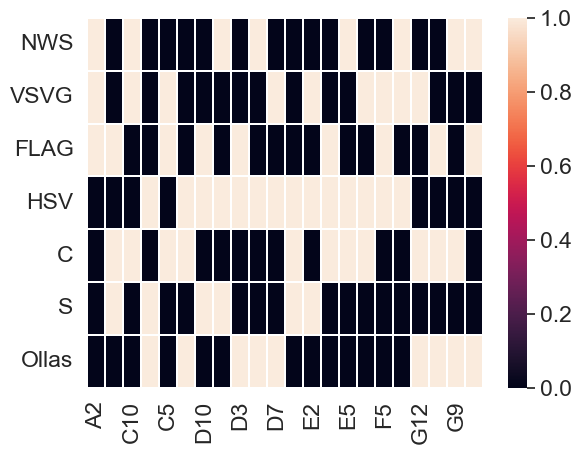

In [112]:
# load codebook
META_DIR = 'metadata'
# load metadata - load full codebook as well
full_codebook = pd.read_csv(f'../{META_DIR}/full_codebook.csv',sep=',', index_col=0) # this is "legal" codebook
Procode_gRNA = pd.read_csv(f'../{META_DIR}/PROCODE_gRNA.csv',sep=',')
legal_codes = sorted(list(set(Procode_gRNA['ProCode ID'].to_list())))
codebook = full_codebook[legal_codes]
#AllProcodes = pd.read_csv('AllProcodes.csv', sep='.')
sns.heatmap(codebook, linewidths = 0.3)
markers = pd.read_csv(f'../{META_DIR}/markers.csv')
#markers.head()

# generate mapping between ProCode ID and Gene
mapping = {}
for row, _ in Procode_gRNA.iterrows():
    pc = Procode_gRNA.loc[row]['ProCode ID']
    gene = Procode_gRNA.loc[row]['Gene Target']
    mapping[pc]=gene
# Applying the mapping to rename the columns
codebook_renamed = codebook.rename(columns=mapping)
codebook_renamed

In [113]:
# get hamming distance. 
from scipy.spatial.distance import pdist, squareform

# Calculate the pairwise Hamming distance between columns
hamming_distances = pdist(codebook_renamed.T, metric='hamming')

# Convert the condensed distance matrix to a square matrix
hamming_distance_matrix = squareform(hamming_distances)

# Create a DataFrame for better visualization
hamming_distance_df = pd.DataFrame(hamming_distance_matrix, 
                                   index=codebook_renamed.columns, 
                                   columns=codebook_renamed.columns)
hamming_distance_df

PGGT1B    MAP4K4      NCK1      HSF1     MINK1      IER5  \
PGGT1B      0.000000  0.571429  0.285714  0.857143  0.285714  0.857143   
MAP4K4      0.571429  0.000000  0.571429  0.571429  0.285714  0.571429   
NCK1        0.285714  0.571429  0.000000  0.857143  0.285714  0.571429   
HSF1        0.857143  0.571429  0.857143  0.000000  0.857143  0.285714   
MINK1       0.285714  0.285714  0.285714  0.857143  0.000000  0.571429   
IER5        0.857143  0.571429  0.571429  0.285714  0.571429  0.000000   
SNX8        0.571429  0.285714  0.857143  0.285714  0.571429  0.571429   
non-target  0.571429  0.571429  0.571429  0.285714  0.857143  0.571429   
PPP2R2B     0.571429  0.571429  0.857143  0.285714  0.571429  0.285714   
FAN1        0.571429  0.857143  0.571429  0.285714  0.857143  0.285714   
MLH1        0.571429  0.857143  0.571429  0.285714  0.571429  0.285714   
MSH3        0.857143  0.285714  0.571429  0.285714  0.571429  0.285714   
PPP2R1A     0.571429  0.571429  0.571429  0.285714  0.571429  0.571429   
HRAS        0.571429  0.285714  0.571429  0.571429  0.285714  0.285714   
SLC25A11    0.571429  0.571429  0.285714  0.571429  0.571429  0.285714   
WASL        0.571429  0.571429  0.285714  0.571429  0.285714  0.285714   
ARPC3       0.285714  0.571429  0.571429  0.571429  0.285714  0.571429   
NCKAP1      0.285714  0.857143  0.285714  0.571429  0.571429  0.571429   
DGKE        0.571429  0.571429  0.285714  0.571429  0.285714  0.285714   
RAPGEF2     0.571429  0.285714  0.571429  0.571429  0.285714  0.285714   
GAS7        0.571429  0.571429  0.285714  0.571429  0.571429  0.285714   
HTT         0.285714  0.571429  0.571429  0.571429  0.571429  0.571429   

                SNX8  non-target   PPP2R2B      FAN1  ...   PPP2R1A      HRAS  \
PGGT1B      0.571429    0.571429  0.571429  0.571429  ...  0.571429  0.571429   
MAP4K4      0.285714    0.571429  0.571429  0.857143  ...  0.571429  0.285714   
NCK1        0.857143    0.571429  0.857143  0.571429  ...  0.571429  0.571429   
HSF1        0.285714    0.285714  0.285714  0.285714  ...  0.285714  0.571429   
MINK1       0.571429    0.857143  0.571429  0.857143  ...  0.571429  0.285714   
IER5        0.571429    0.571429  0.285714  0.285714  ...  0.571429  0.285714   
SNX8        0.000000    0.285714  0.285714  0.571429  ...  0.285714  0.285714   
non-target  0.285714    0.000000  0.571429  0.285714  ...  0.285714  0.571429   
PPP2R2B     0.285714    0.571429  0.000000  0.285714  ...  0.571429  0.285714   
FAN1        0.571429    0.285714  0.285714  0.000000  ...  0.571429  0.571429   
MLH1        0.571429    0.571429  0.285714  0.285714  ...  0.285714  0.571429   
MSH3        0.285714    0.285714  0.571429  0.571429  ...  0.285714  0.285714   
PPP2R1A     0.285714    0.285714  0.571429  0.571429  ...  0.000000  0.571429   
HRAS        0.285714    0.571429  0.285714  0.571429  ...  0.571429  0.000000   
SLC25A11    0.571429    0.285714  0.571429  0.285714  ...  0.571429  0.285714   
WASL        0.571429    0.571429  0.571429  0.571429  ...  0.285714  0.285714   
ARPC3       0.285714    0.571429  0.285714  0.571429  ...  0.285714  0.285714   
NCKAP1      0.571429    0.285714  0.571429  0.285714  ...  0.285714  0.571429   
DGKE        0.857143    0.857143  0.571429  0.571429  ...  0.571429  0.571429   
RAPGEF2     0.571429    0.857143  0.285714  0.571429  ...  0.857143  0.285714   
GAS7        0.857143    0.571429  0.571429  0.285714  ...  0.857143  0.571429   
HTT         0.571429    0.571429  0.285714  0.285714  ...  0.857143  0.571429   

            SLC25A11      WASL     ARPC3    NCKAP1      DGKE   RAPGEF2  \
PGGT1B      0.571429  0.571429  0.285714  0.285714  0.571429  0.571429   
MAP4K4      0.571429  0.571429  0.571429  0.857143  0.571429  0.285714   
NCK1        0.285714  0.285714  0.571429  0.285714  0.285714  0.571429   
HSF1        0.571429  0.571429  0.571429  0.571429  0.571429  0.571429   
MINK1       0.571429  0.285714  0.285714  0.571429  0.285714  0.285714   
IER

In [114]:
# is similarity profile correlated with codebook similarity? 

# assess rep-rep correlation
genes = pairwise_clf_results_auc['D10_STD'].columns

# generate geneA_geneB index
index_combinations = []
for i in range(len(genes)):
    for j in range(i+1, len(genes)):
        index_combinations.append(genes[i]+'_'+genes[j])
# initialize

corr_df = pd.DataFrame(index=index_combinations, columns=['Cosine', 'Codebook', 'AUC'])

# define codebook_df
codebook_df = 1-hamming_distance_df

for i in range(len(genes)):
    for j in range(i+1, len(genes)):
        geneA = pairwise_clf_results_auc['D10_STD'].columns[i]
        geneB = pairwise_clf_results_auc['D10_STD'].columns[j] 
        #corr_df.loc[genes[i]+'_'+genes[j]]['Cosine'] = cosine_dist_dfs['D10_STD'].loc[geneA, geneB]
        corr_df.loc[genes[i]+'_'+genes[j]]['AUC'] = pairwise_clf_results_auc['D10_STD'].loc[geneA, geneB]
        corr_df.loc[genes[i]+'_'+genes[j]]['Codebook'] = codebook_df.loc[geneA, geneB]
corr_df

Cosine  Codebook       AUC
ARPC3_FAN1          NaN  0.428571  0.767348
ARPC3_IER5          NaN  0.428571   0.61056
ARPC3_RAPGEF2       NaN  0.428571   0.55995
ARPC3_DGKE          NaN  0.428571  0.541781
ARPC3_non-target    NaN  0.428571  0.723712
...                 ...       ...       ...
HRAS_PGGT1B         NaN  0.428571   0.70928
HRAS_SNX8           NaN  0.714286  0.803817
HSF1_PGGT1B         NaN  0.142857  0.590685
HSF1_SNX8           NaN  0.714286  0.593386
PGGT1B_SNX8         NaN  0.428571  0.655116

[231 rows x 3 columns]

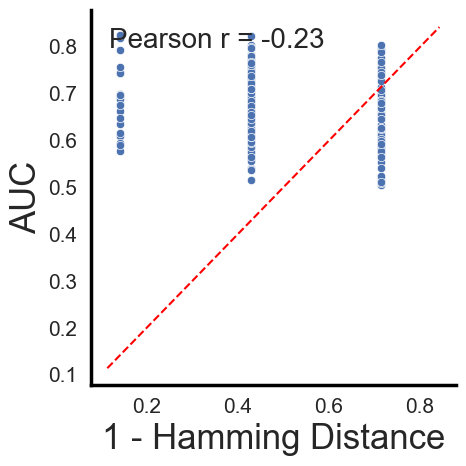

In [117]:
# generate replicate-replicate plot; each dot is geneA-geneB classification accuracy in particular replicate.
fig, ax = plt.subplots(1,1, figsize= (5,5))
sns.scatterplot(data=corr_df, x='Codebook', y = 'AUC', ax=ax)

#tick_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#tick_values = [0.0, 0.25, 0.5, 0.75,1.0]

sample1 = 'Codebook'
sample2 = 'AUC'

x_vals = ax.get_xlim()
y_vals = ax.get_ylim()
    
    #ax.set_xlim(0.4, 1.0)
    #ax.set_ylim(0.4, 1.0)
    #ax.set_xticks(tick_values)
    #ax.set_yticks(tick_values)
    
ax.set_facecolor('white')
ax.set_xlabel('1 - Hamming Distance',fontsize=25)
ax.set_ylabel('AUC',fontsize=25)
ax.tick_params(axis='both', labelsize = 15)
min_val = min(x_vals[0], y_vals[0])
max_val = max(x_vals[1], y_vals[1])
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
    
corr_coef, _ = utils.pearsonr(corr_df[sample1], corr_df[sample2])
ax.text(0.05, 0.9, f'Pearson r = {corr_coef:.2f}', transform=ax.transAxes, fontsize=20)
plt.tight_layout()
#plt.savefig('../Figures/D28_STD_Correlation_Cosine_vs_Hamming.png', format='png',dpi=300)
#plt.savefig('../Figures/D28_STD_Correlation_Cosine_vs_Hamming.eps', format='eps',dpi=300)


In [118]:
# how about intensity - based similarity? 
genes = pairwise_clf_results_auc['D10_STD'].columns

# generate geneA_geneB index
index_combinations = []
for i in range(len(genes)):
    for j in range(i+1, len(genes)):
        index_combinations.append(genes[i]+'_'+genes[j])
# initialize

corr_df = pd.DataFrame(index=index_combinations, columns=['Cosine', 'Codebook', 'AUC'])

# define tag_df
tag_df = cos_procode_dfs['D10_STD'] # cosine simlarity based on intensity_mean_x

# D28_AO
for i in range(len(genes)):
    for j in range(i+1, len(genes)):
        geneA = pairwise_clf_results_auc['D10_STD'].columns[i]
        geneB = pairwise_clf_results_auc['D10_STD'].columns[j] 
        #corr_df.loc[genes[i]+'_'+genes[j]]['Cosine'] = cosine_dist_dfs['D10_STD'].loc[geneA, geneB]
        corr_df.loc[genes[i]+'_'+genes[j]]['AUC'] = pairwise_clf_results_auc['D10_STD'].loc[geneA, geneB]
        corr_df.loc[genes[i]+'_'+genes[j]]['Codebook'] = tag_df.loc[geneA, geneB]
corr_df

Cosine  Codebook       AUC
ARPC3_FAN1          NaN  0.527541  0.767348
ARPC3_IER5          NaN  0.554989   0.61056
ARPC3_RAPGEF2       NaN   0.63317   0.55995
ARPC3_DGKE          NaN  0.824465  0.541781
ARPC3_non-target    NaN  0.525623  0.723712
...                 ...       ...       ...
HRAS_PGGT1B         NaN  0.635365   0.70928
HRAS_SNX8           NaN  0.477009  0.803817
HSF1_PGGT1B         NaN  0.447965  0.590685
HSF1_SNX8           NaN  0.981729  0.593386
PGGT1B_SNX8         NaN  0.524684  0.655116

[231 rows x 3 columns]

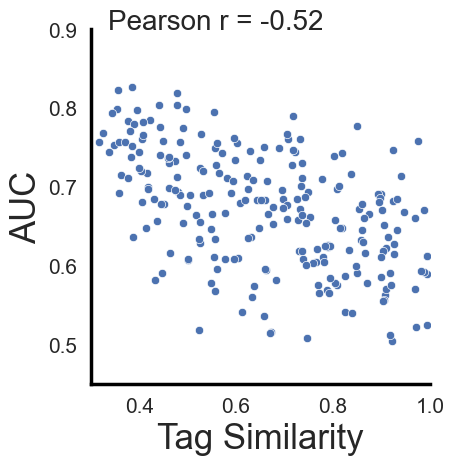

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(data=corr_df, x='Codebook', y='AUC', ax=ax)
#sns.scatterplot(data=corr_df, x='Codebook', y='AUC', ax=axs[1])

sample1 = 'Codebook'
sample2 = 'AUC'
x_vals = ax.get_xlim()
y_vals = ax.get_ylim()
ax.set_xlim(0.3, 1.0)
ax.set_ylim(0.45, 0.9)
ax.set_facecolor('white')
ax.set_xlabel('Tag Similarity', fontsize=25)
ax.set_ylabel(sample2, fontsize=25)
ax.tick_params(axis='both', labelsize=15)
    
for spine in ax.spines.values():
    spine.set_linewidth(2.5)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
corr_coef, _ = utils.pearsonr(corr_df[sample1], corr_df[sample2])
ax.text(0.05, 1.0, f'Pearson r = {corr_coef:.2f}', transform=ax.transAxes, fontsize=20)

plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_Correlation_AUC_vs_Tag.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_Correlation_AUC_vs_Tag.eps', format='eps',dpi=300)


## Plot histograms for individual features, related to Fig 4B-g

In [120]:
# load data
adata = sc.read(ADATA_DIR)
    
# clf results
with open(f'{RESULT_DIR}/pairwise_clf_results_auc.pkl', 'rb') as handle:
    pairwise_clf_results_auc=pickle.load(handle)
    
# ks results
with open(f'{RESULT_DIR}/ks_results_store', 'rb') as handle:
    ks_results_store = pickle.load(handle)

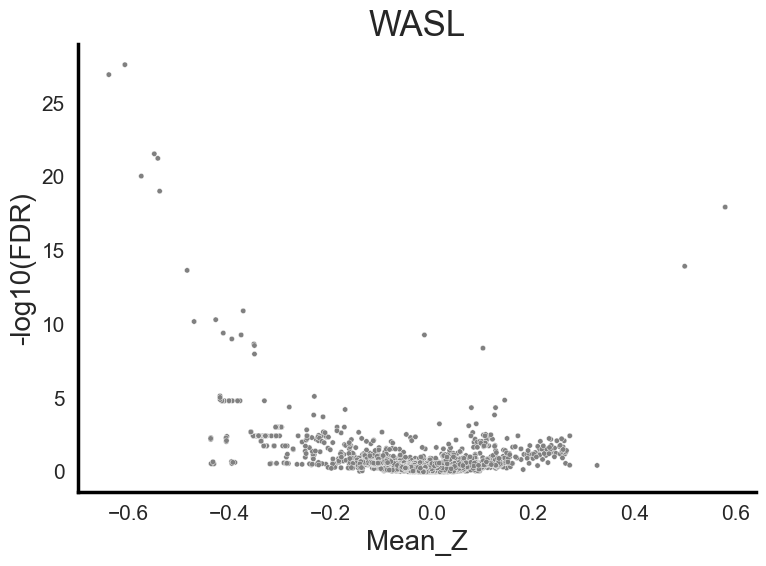

In [121]:
# volcano plot
# single volcano
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
gene = 'WASL'; protein = 'Golgin97_' # do not annotate for this plot; 
color_map = {0: 'gray', 1: 'red'}
Z_thres, p_thres = 0.1, 0.05
veto = 'Correlation'
df1 = ks_results_store['D10_STD'][gene]
categories = list(set([x.split('_')[0] for x in adata.var.index]))
categories.remove('Neighbors')
categ = categories[0]
fig, axs = plt.subplots(1, 1, figsize = (8,6))
L1, df1 = utils.annotate_protein_volcano(df1, Z_thres, p_thres, protein, None, 'Mean_Z')
utils.plot_diff_features(df1, axs, 'annotate', 'Mean_Z','-log10(FDR)', color_map, gene)
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_WASL_Volcano.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_WASL_Volcano.eps', format='eps',dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


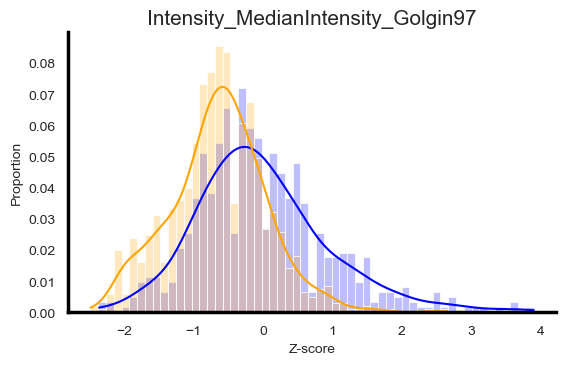

In [156]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_Golgin97'
gene = 'WASL'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_Golgin97', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_WASL_Histogram_Golgin97.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_WASL_Histogram_Golgin97.eps', format='eps',dpi=300)


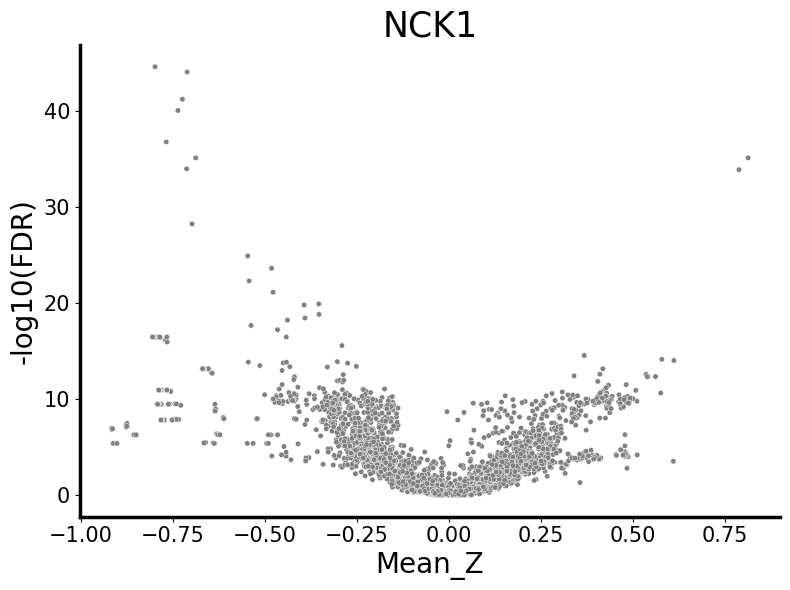

In [33]:
# volcano plot
# single volcano
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
gene = 'NCK1'; protein = 'Golgin97_' # do not annotate for this plot; 
color_map = {0: 'gray', 1: 'red'}
Z_thres, p_thres = 0.1, 0.05
veto = 'Correlation'
df1 = ks_results_store['D10_STD'][gene]
categories = list(set([x.split('_')[0] for x in adata.var.index]))
categories.remove('Neighbors')
categ = categories[0]
fig, axs = plt.subplots(1, 1, figsize = (8,6))
L1, df1 = utils.annotate_protein_volcano(df1, Z_thres, p_thres, protein, None, 'Mean_Z')
utils.plot_diff_features(df1, axs, 'annotate', 'Mean_Z','-log10(FDR)', color_map, gene)
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_NCK1_Volcano.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_NCK1_Volcano.eps', format='eps',dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


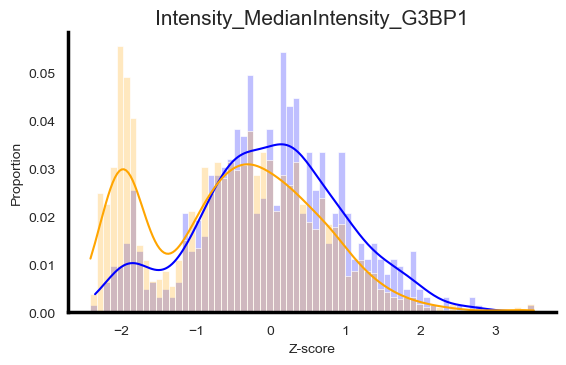

In [150]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_G3BP1'
gene = 'NCK1'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_G3BP1', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
#axs.legend_.remove()
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_NCK1_Histogram_G3BP1.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_NCK1_Histogram_G3BP1.eps', format='eps',dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


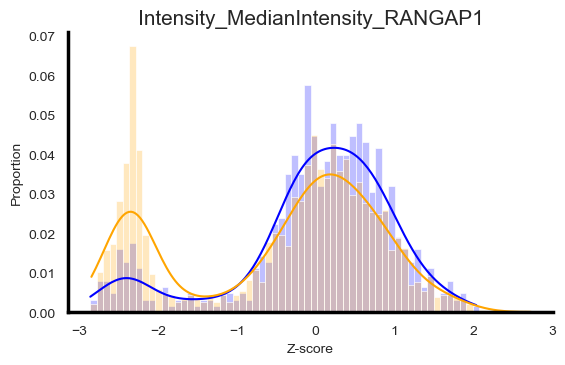

In [151]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_RANGAP1'
gene = 'NCK1'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_RANGAP1', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
#axs.legend_.remove()
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_NCK1_Histogram_RANGAP1.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_NCK1_Histogram_RANGAP1.eps', format='eps',dpi=300)


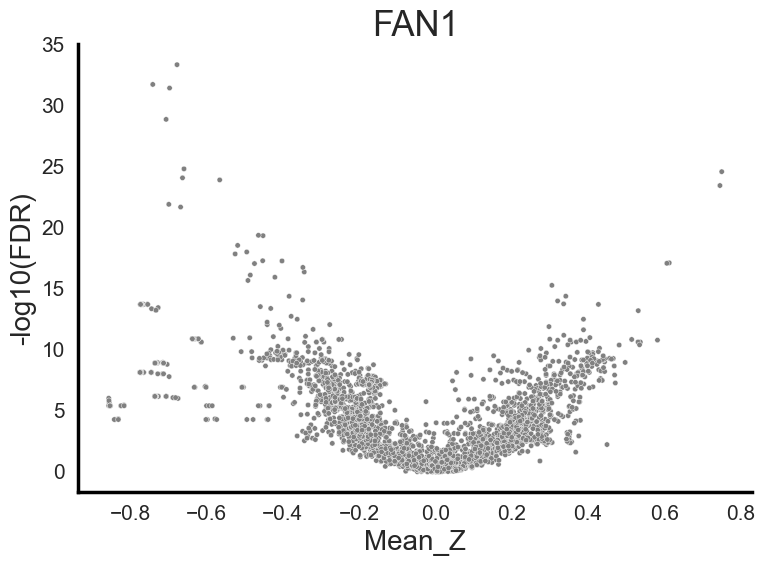

In [134]:
# volcano plot
# single volcano
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
gene = 'FAN1'; protein = 'Golgin97_' # do not annotate for this plot; 
color_map = {0: 'gray', 1: 'red'}
Z_thres, p_thres = 0.1, 0.05
veto = 'Correlation'
df1 = ks_results_store['D10_STD'][gene]
categories = list(set([x.split('_')[0] for x in adata.var.index]))
categories.remove('Neighbors')
categ = categories[0]
fig, axs = plt.subplots(1, 1, figsize = (8,6))
L1, df1 = utils.annotate_protein_volcano(df1, Z_thres, p_thres, protein, None, 'Mean_Z')
utils.plot_diff_features(df1, axs, 'annotate', 'Mean_Z','-log10(FDR)', color_map, gene)
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_FAN1_Volcano.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_FAN1_Volcano.eps', format='eps',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


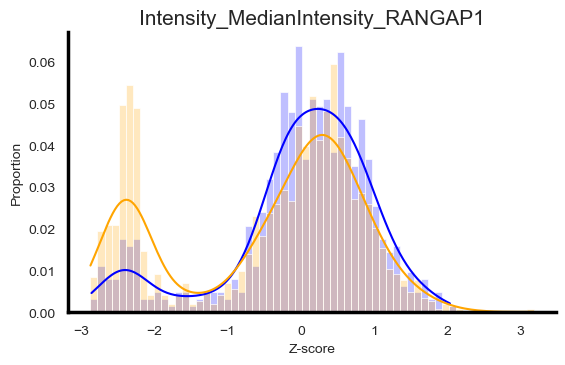

In [160]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_RANGAP1'
gene = 'FAN1'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_RANGAP1', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
#axs.legend_.remove()
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_FAN1_Histogram_RANGAP1.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_FAN1_Histogram_RANGAP1.eps', format='eps',dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


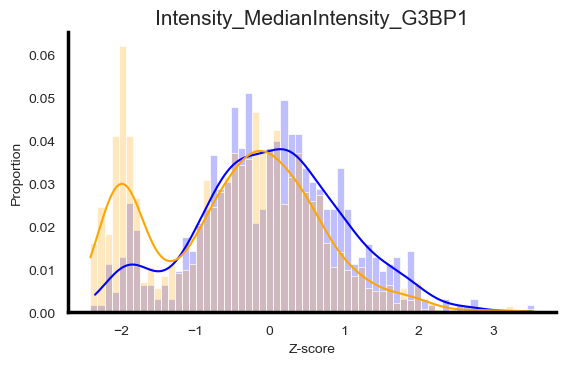

In [162]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_G3BP1'
gene = 'FAN1'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_G3BP1', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
#axs.legend_.remove()
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_FAN1_Histogram_G3BP1.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_FAN1_Histogram_G3BP1.eps', format='eps',dpi=300)


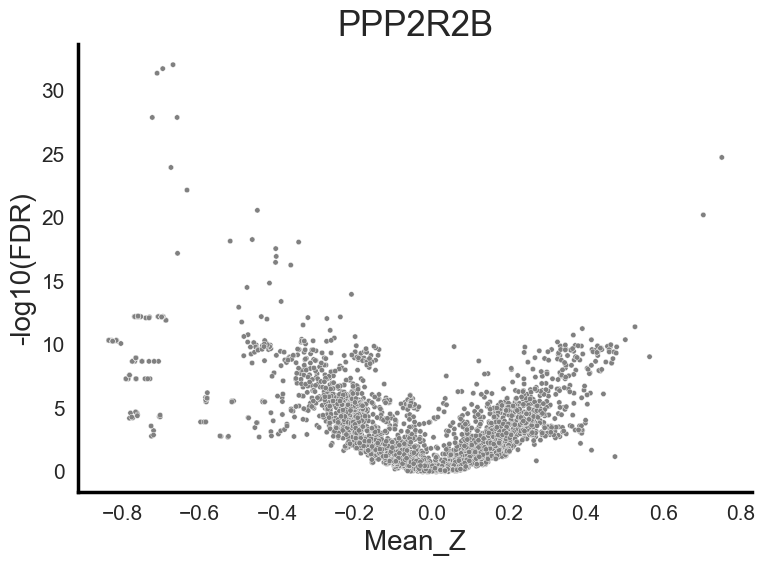

In [135]:
# volcano plot
# single volcano
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
gene = 'PPP2R2B'; protein = 'Golgin97_' # do not annotate for this plot; 
color_map = {0: 'gray', 1: 'red'}
Z_thres, p_thres = 0.1, 0.05
veto = 'Correlation'
df1 = ks_results_store['D10_STD'][gene]
categories = list(set([x.split('_')[0] for x in adata.var.index]))
categories.remove('Neighbors')
categ = categories[0]
fig, axs = plt.subplots(1, 1, figsize = (8,6))
L1, df1 = utils.annotate_protein_volcano(df1, Z_thres, p_thres, protein, None, 'Mean_Z')
utils.plot_diff_features(df1, axs, 'annotate', 'Mean_Z','-log10(FDR)', color_map, gene)
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_Volcano.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_Volcano.eps', format='eps',dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


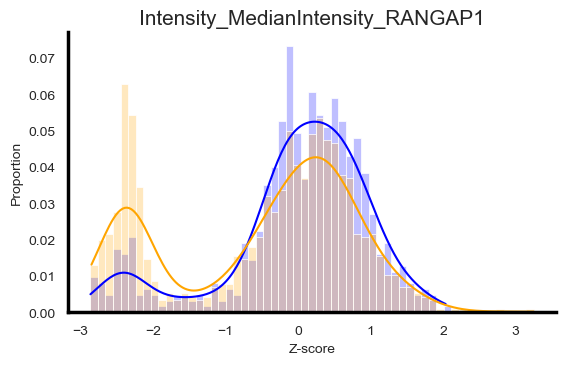

In [164]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_RANGAP1'
gene = 'PPP2R2B'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_RANGAP1', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
#axs.legend_.remove()
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_Histogram_RANGAP1.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_Histogram_RANGAP1.eps', format='eps',dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


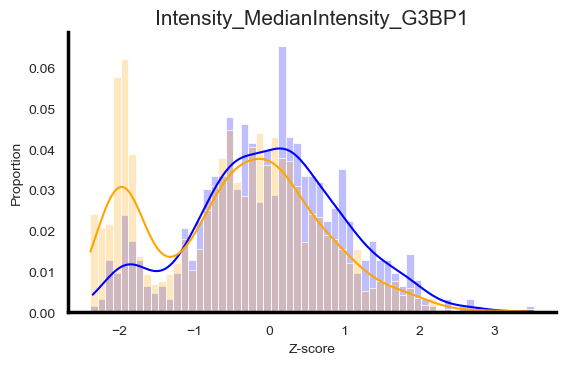

In [165]:
# histogram and cdf
# subset data
plt.close('all')
data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]
fig, axs = plt.subplots(1,1, figsize = (6,4))
feature = 'Intensity_MedianIntensity_G3BP1'
gene = 'PPP2R2B'
data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
data2 = data[data.obs.Gene == gene,feature].X.flatten()

data1 = data1[data1<5]
data2 = data2[data2<5]

utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs,
                               xtick_fontsize = 10, ytick_fontsize= 10, xlabel_fontsize = 10, 
                                ylabel_fontsize = 10)
#utils.plot_cdf(data1, data2, ax=axs[1], label1='non-target', label2=gene, 
#         title=feature, xlabel='z-scores', ylabel='Cumulative Density')
axs.set_title('Intensity_MedianIntensity_G3BP1', fontsize = 15)
#legend = axs.legend(['non-target', gene], loc='lower right', bbox_to_anchor=(1.4, 0),
#                     fontsize=8, frameon=True)
#legend.get_frame().set_facecolor('white')  # Set legend face color to white
#legend.get_frame().set_edgecolor('black')
#axs.legend_.remove()
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_Histogram_G3BP1.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_Histogram_G3BP1.eps', format='eps',dpi=300)


## Plot individual cells

In [166]:
print(ADATA_DIR)
print(RESULT_DIR)

../adata_integrated/D10_STD_adata.h5ad
../Fig4_Results


In [168]:
# load data
im_df = pd.read_pickle('../cropped_images_combined_all_cells.pkl')

adata = sc.read(ADATA_DIR)

with open(f'{RESULT_DIR}/pairwise_clf_results_auc.pkl','rb') as f:
    pairwise_clf_results_auc = pickle.load(f)

with open(f'{RESULT_DIR}/ks_results_store', 'rb') as f:
    ks_results_store=pickle.load(f)


In [173]:
# subset
# slice data to synchronize -- remove out-of-bound cells when cropping 
inds = list(set(im_df.index).intersection(adata.obs.index))
im_df = im_df.loc[inds]
adata = adata[inds]
print(im_df.shape, adata.shape)

(22457, 22) (22457, 2827)


In [174]:
# channel id
channels= ['DNA','NeuN','pRPS6','RANGAP1','NFKB','TOM20','LAMP1','TDP43','G3BP1','GM130','Golgin97','SYTO','ER','AGP']
print(len(channels))

14


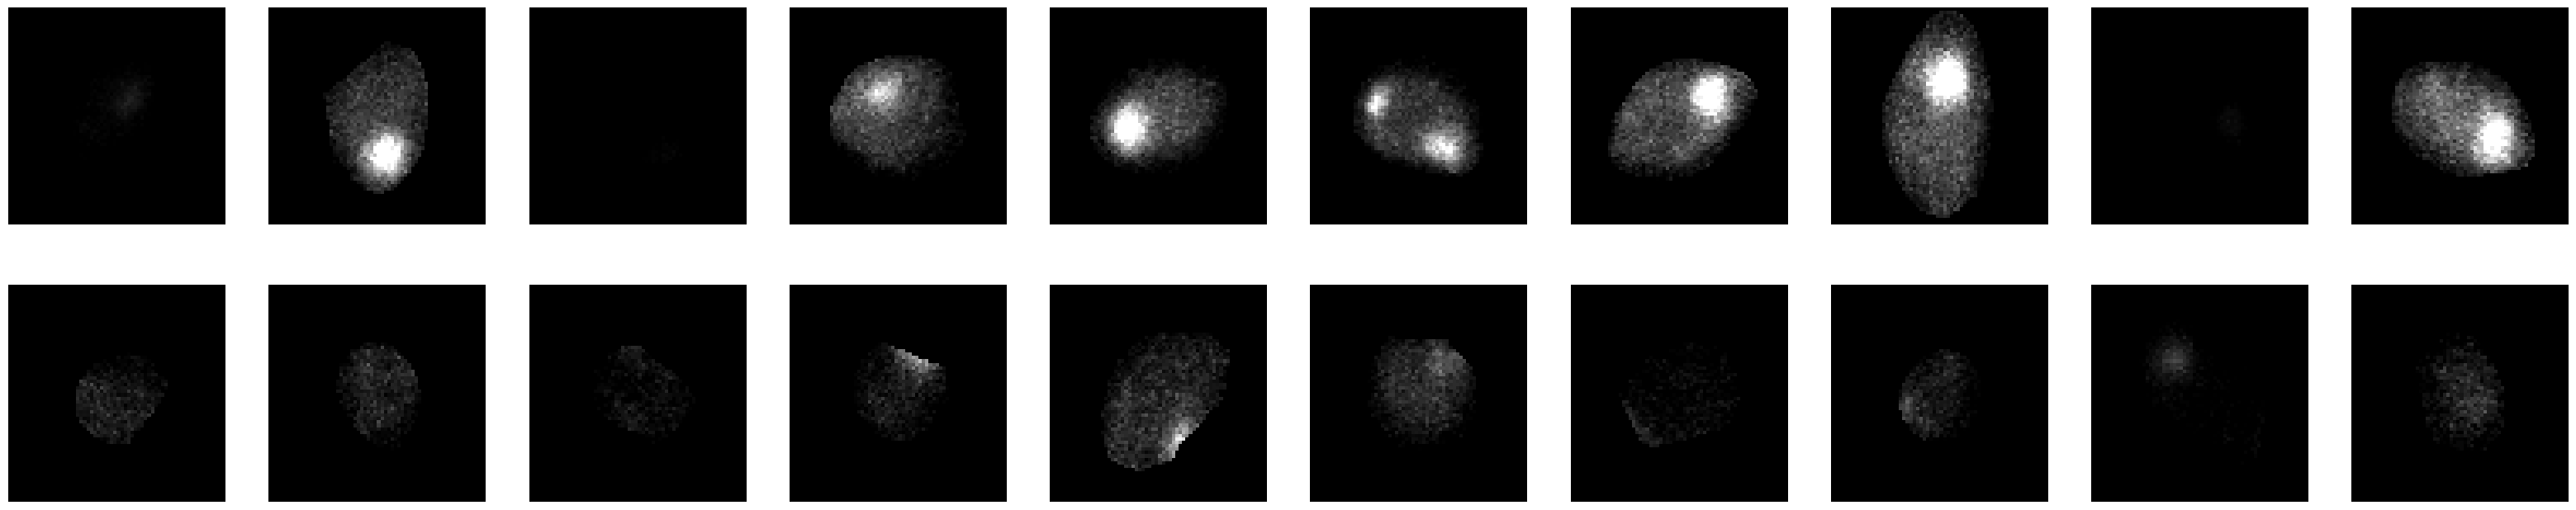

In [201]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(2,10, figsize = (40,8))

# define constants
feature_name = 'Intensity_MeanIntensity_Golgin97'
MIN1 = 0.5; MAX1 = 1; MIN2 = -2; MAX2 = -1;
n_cells = 10
seed = 12
channel = 'Golgin97'
ch = channels.index(channel)
gene = 'WASL'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    

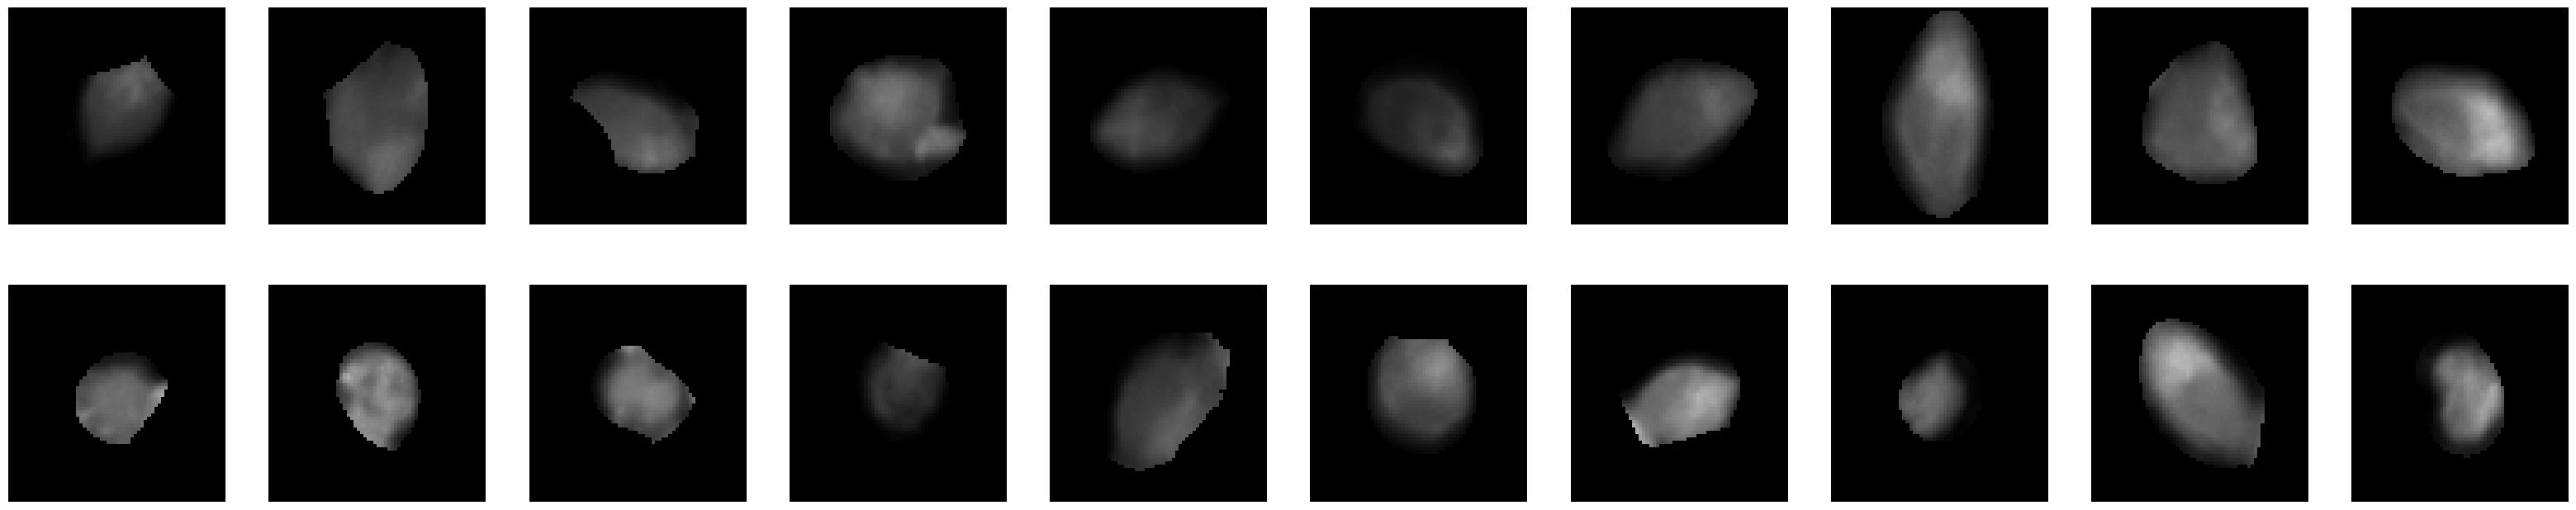

In [202]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(2,10, figsize = (40,8))

ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 255, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 255, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    

In [203]:
print(cells1)
print(cells2)

['86348_STD1_D10', '29469_STD2_D10', '86785_STD1_D10', '59907_STD2_D10', '47359_STD2_D10', '62642_STD2_D10', '62965_STD1_D10', '61758_STD2_D10', '53764_STD1_D10', '43946_STD2_D10']
['30206_STD2_D10', '33417_STD2_D10', '8649_STD1_D10', '61074_STD2_D10', '11407_STD1_D10', '46100_STD2_D10', '89573_STD1_D10', '54495_STD1_D10', '94811_STD1_D10', '4571_STD1_D10']


['62965_STD1_D10', '61758_STD2_D10', '62965_STD1_D10', '61758_STD2_D10'] ['89573_STD1_D10', '94811_STD1_D10', '89573_STD1_D10', '94811_STD1_D10']


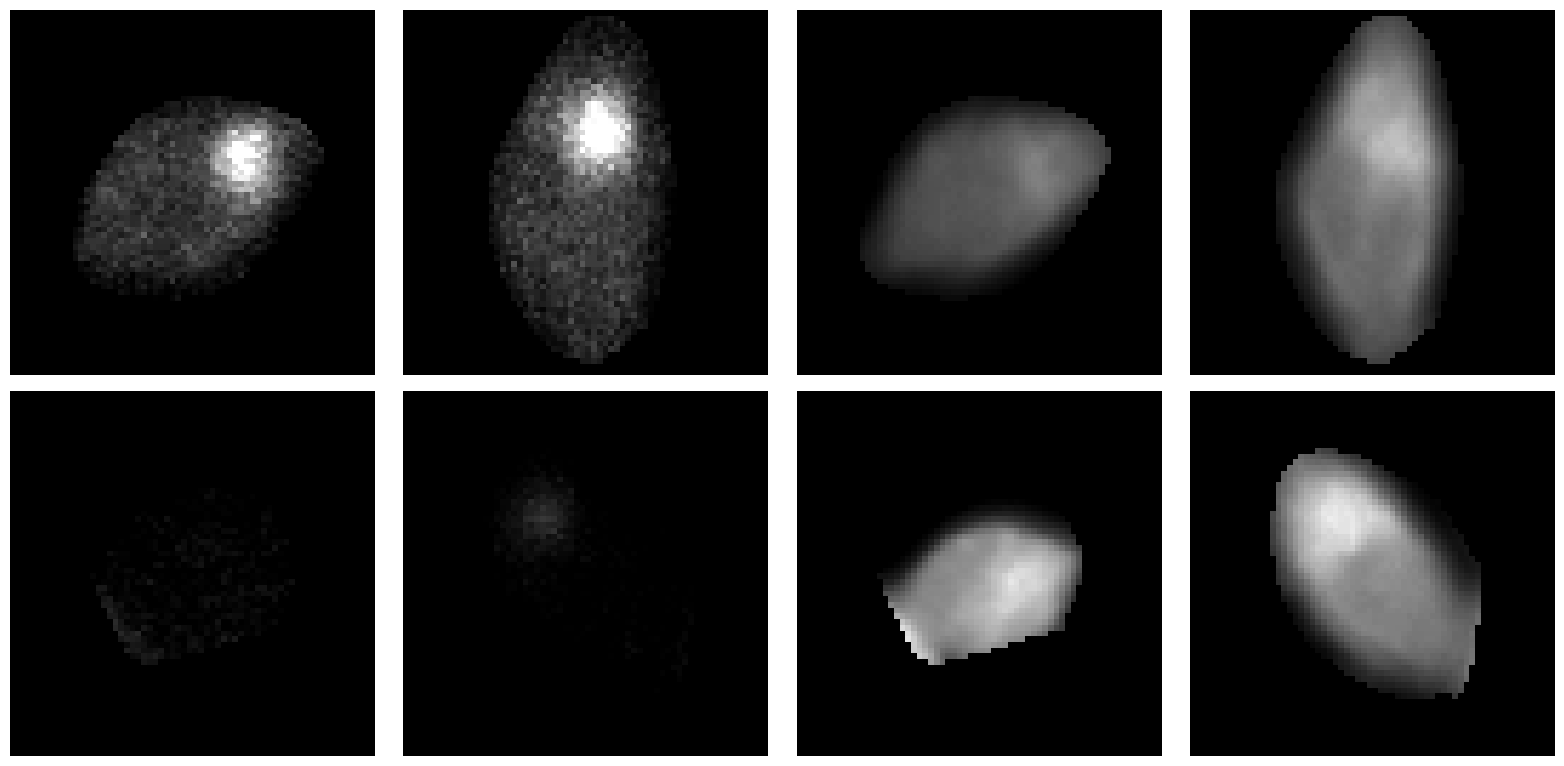

In [205]:
final_cells1 = [cells1[6]] + [cells1[7]] 
final_cells2 = [cells2[6]] + [cells2[8]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['Golgin97','Golgin97','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = 200, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = 200, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_WASL_Golgin97_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_WASL_Golgin97_Example.eps', format='eps',dpi=300)


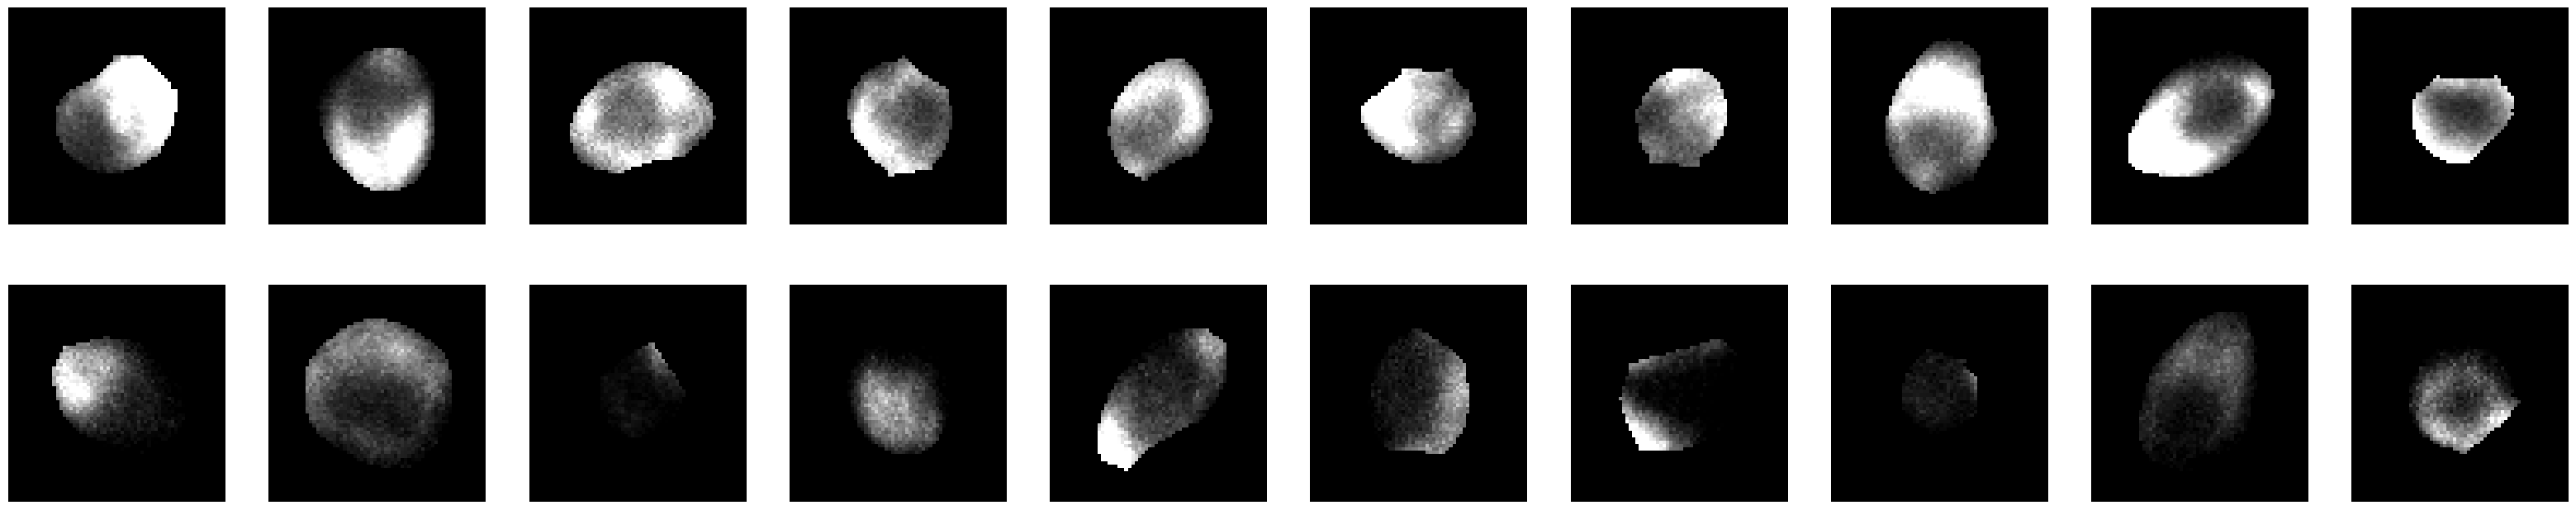

In [210]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(2,10, figsize = (40,8))

# define constants
feature_name = 'Intensity_MeanIntensity_G3BP1'
MIN1 = 1; MAX1 = 2; MIN2 = -2; MAX2 = -1;
n_cells = 10
seed = 1
channel = 'G3BP1'
ch = channels.index(channel)
gene = 'NCK1'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    

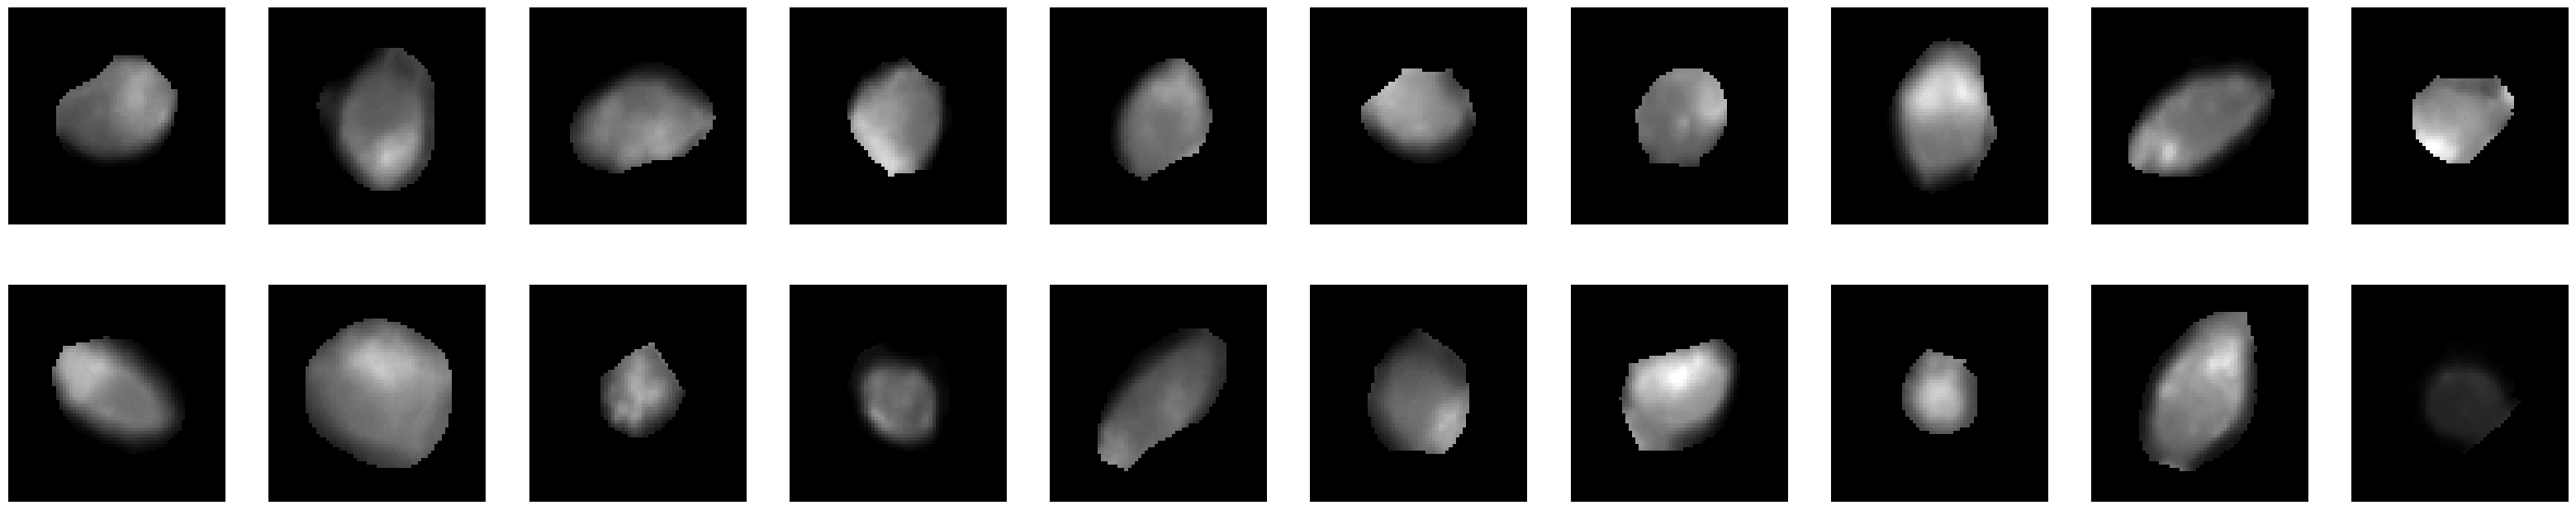

In [211]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(2,10, figsize = (40,8))

ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 255, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 255, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    

['82773_STD1_D10', '5321_STD1_D10', '82773_STD1_D10', '5321_STD1_D10'] ['94462_STD1_D10', '94270_STD1_D10', '94462_STD1_D10', '94270_STD1_D10']


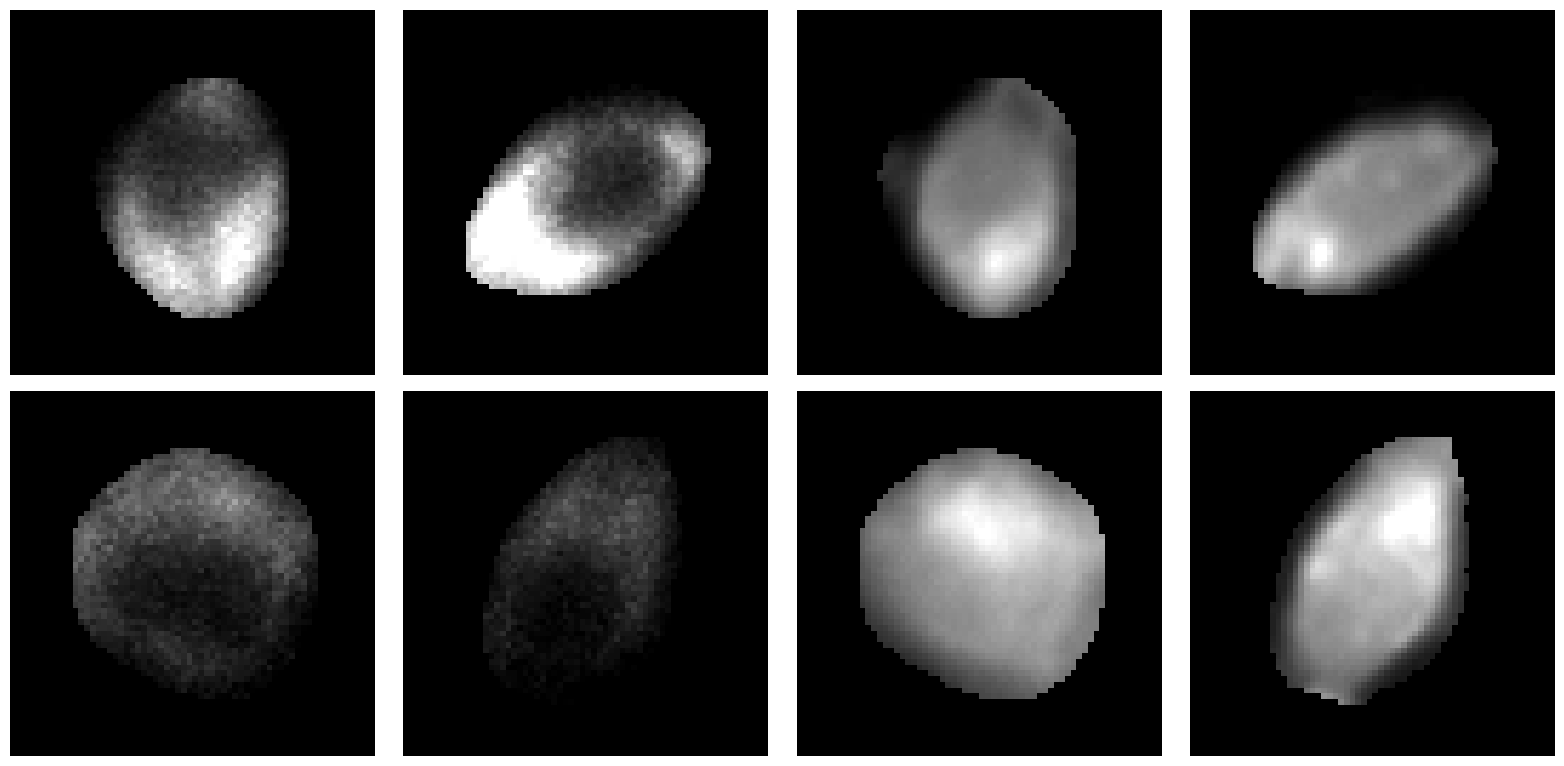

In [213]:
final_cells1 = [cells1[1]] + [cells1[8]] 
final_cells2 = [cells2[1]] + [cells2[8]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['G3BP1','G3BP1','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = 200, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = 200, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_NCK1_G3BP1_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_NCK1_G3BP1_Example.eps', format='eps',dpi=300)


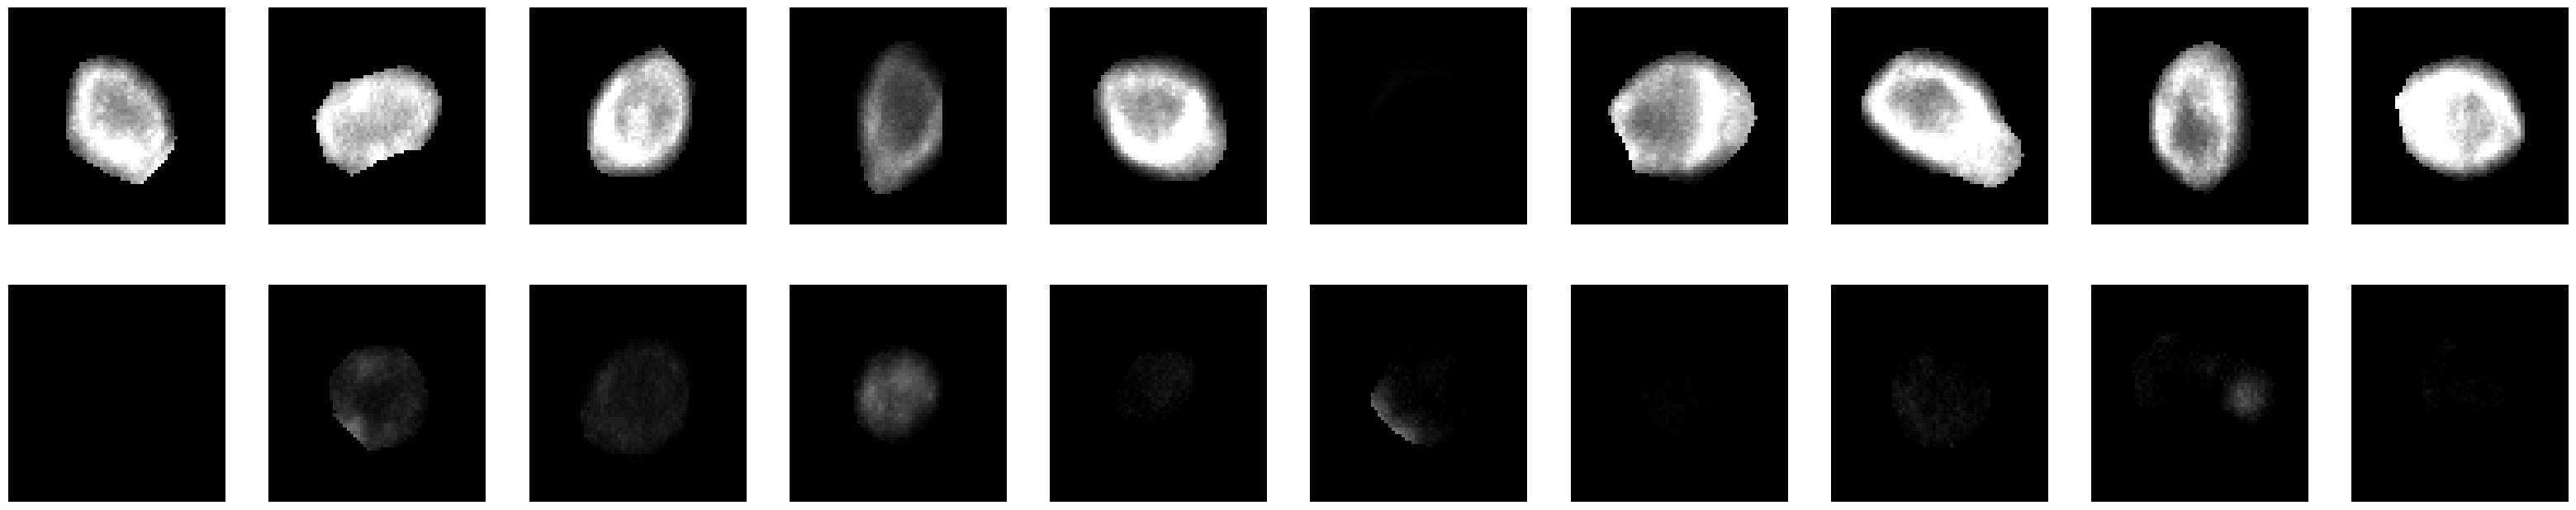

In [252]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(2,10, figsize = (40,8))

# define constants
feature_name = 'Intensity_MeanIntensity_RANGAP1'
MIN1 = 0; MAX1 = 1; MIN2 = -2.5; MAX2 = -1.5;
n_cells = 10
seed = 1234
channel = 'RANGAP1'
ch = channels.index(channel)
gene = 'NCK1'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    

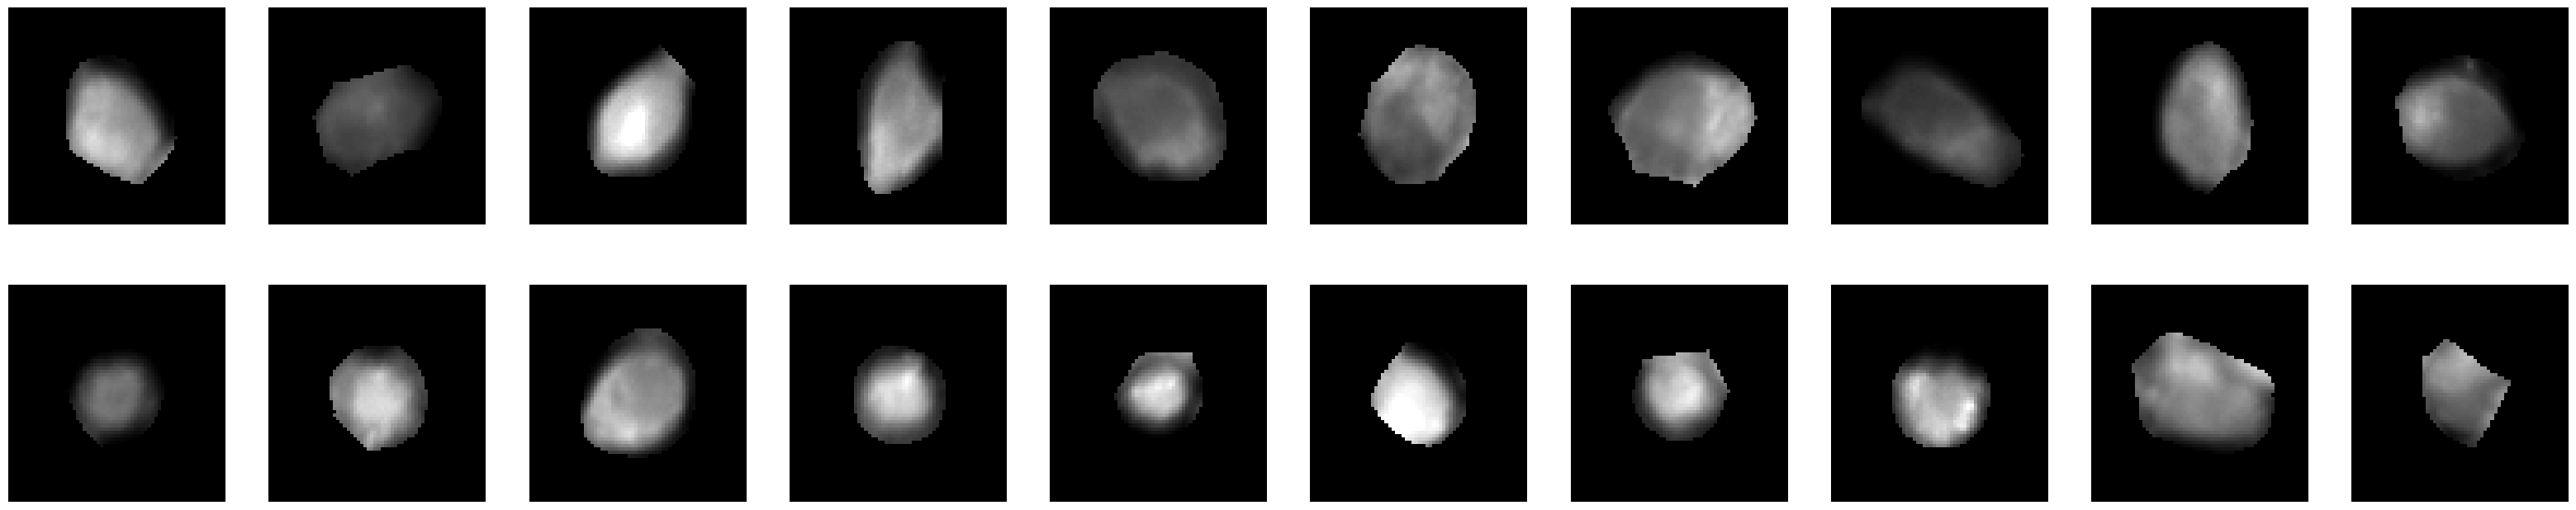

In [253]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(2,10, figsize = (40,8))

ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 200, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 200, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    

['23503_STD2_D10', '45771_STD2_D10', '23503_STD2_D10', '45771_STD2_D10'] ['70991_STD1_D10', '70141_STD1_D10', '70991_STD1_D10', '70141_STD1_D10']


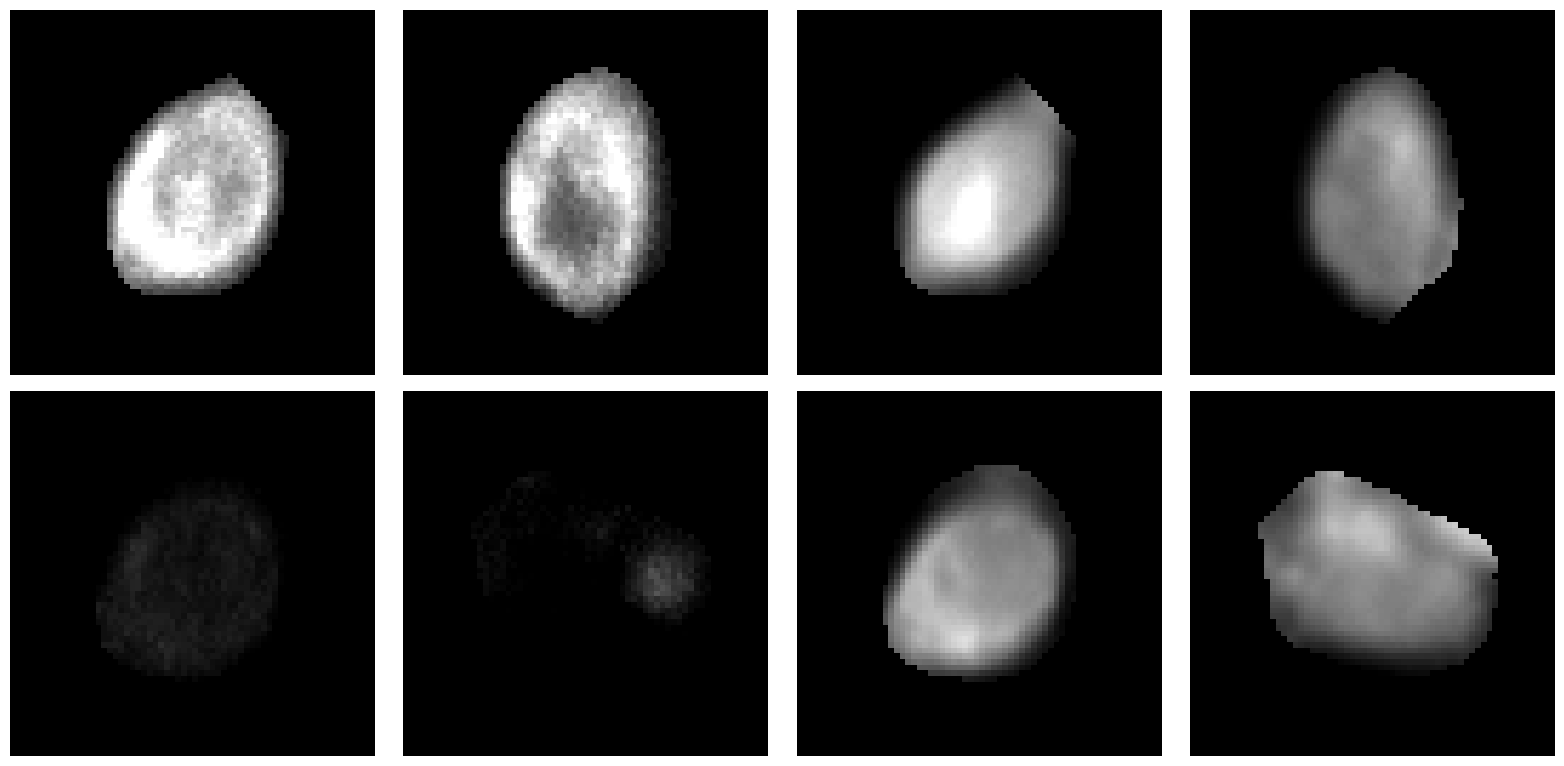

In [256]:
final_cells1 = [cells1[2]] + [cells1[8]] 
final_cells2 = [cells2[2]] + [cells2[8]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['RANGAP1','RANGAP1','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    if channels_to_plot[i] == 'ER':
        VMAX = 200
    else:
        VMAX = 150
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_NCK1_RANGAP1_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_NCK1_RANGAP1_Example.eps', format='eps',dpi=300)


## FAN1 and PPP2R2B for supplementary

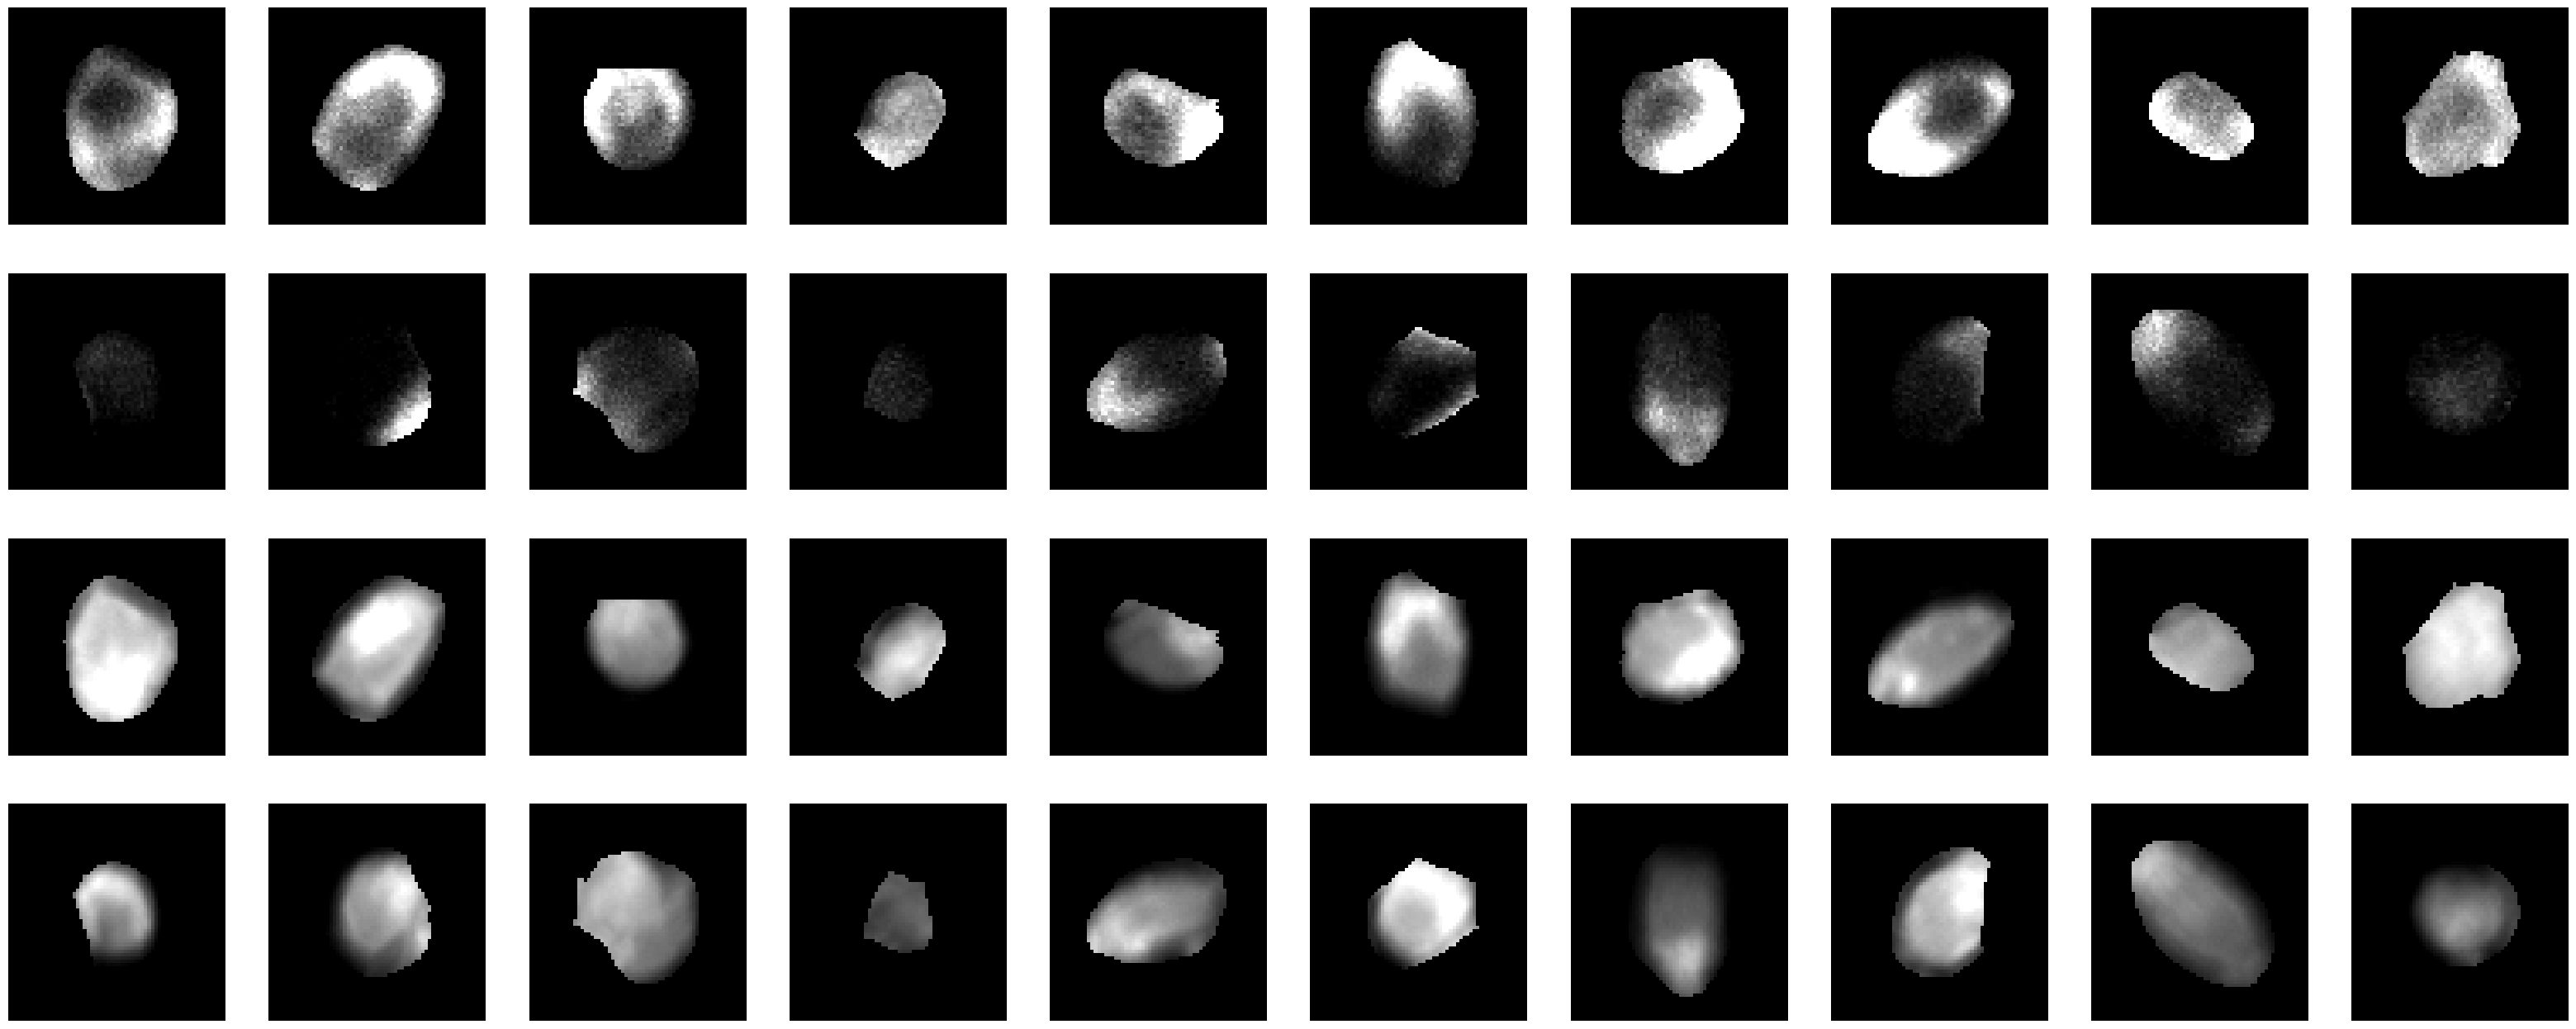

In [258]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(4,10, figsize = (40,16))

# define constants
feature_name = 'Intensity_MeanIntensity_G3BP1'
MIN1 = 1; MAX1 = 2; MIN2 = -2; MAX2 = -1;
n_cells = 10
seed = 123
channel = 'G3BP1'
ch = channels.index(channel)
gene = 'FAN1'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    
ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[2][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 200, cmap ='gray')
    axs[3][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 200, cmap = 'gray')
    axs[2][i].axis('off')
    axs[3][i].axis('off')
    

['104286_STD1_D10', '5321_STD1_D10', '104286_STD1_D10', '5321_STD1_D10'] ['62473_STD2_D10', '82539_STD1_D10', '62473_STD2_D10', '82539_STD1_D10']


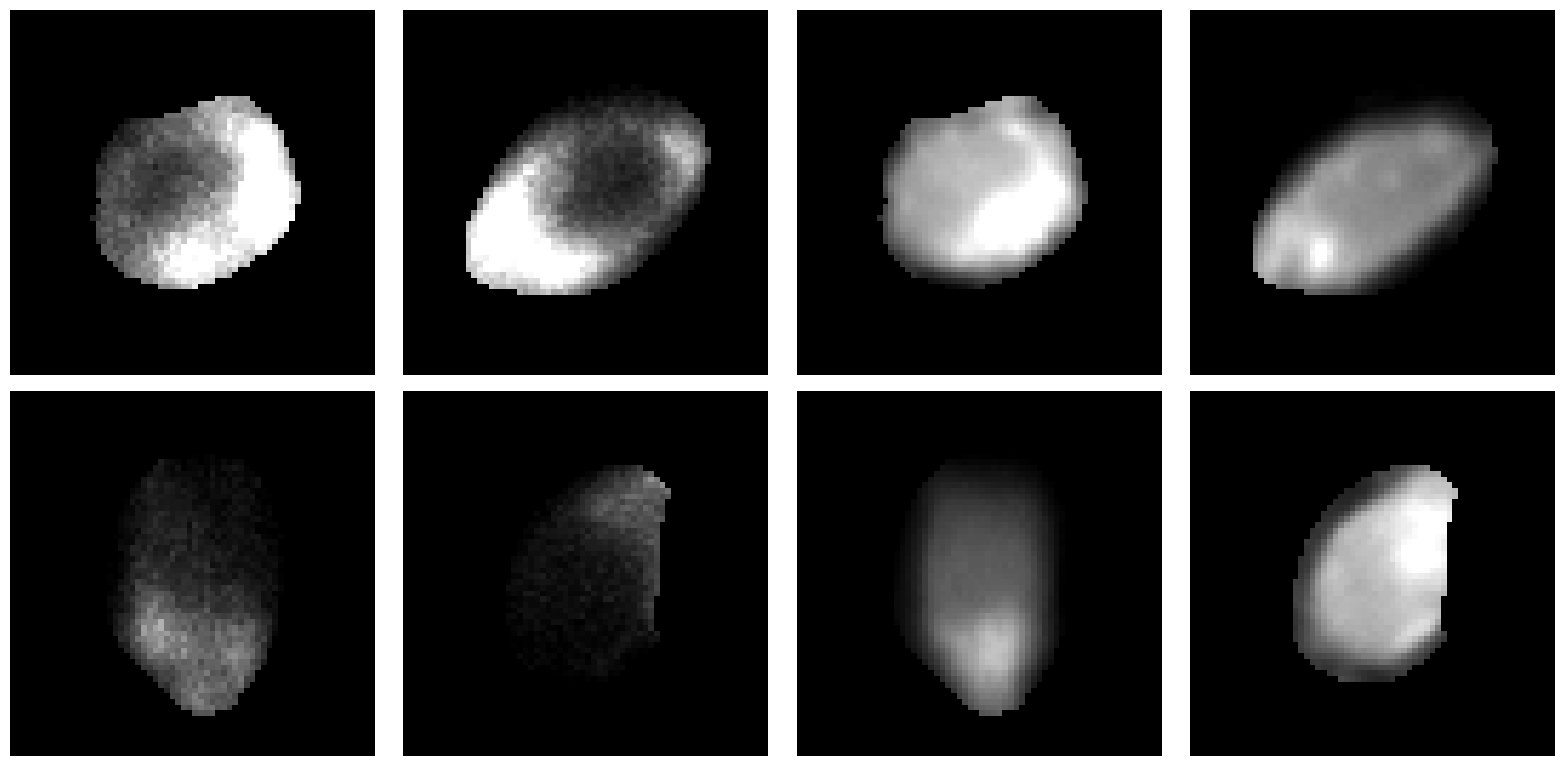

In [259]:
final_cells1 = [cells1[6]] + [cells1[7]] 
final_cells2 = [cells2[6]] + [cells2[7]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['G3BP1','G3BP1','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = 200, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = 200, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_FAN1_G3BP1_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_FAN1_G3BP1_Example.eps', format='eps',dpi=300)


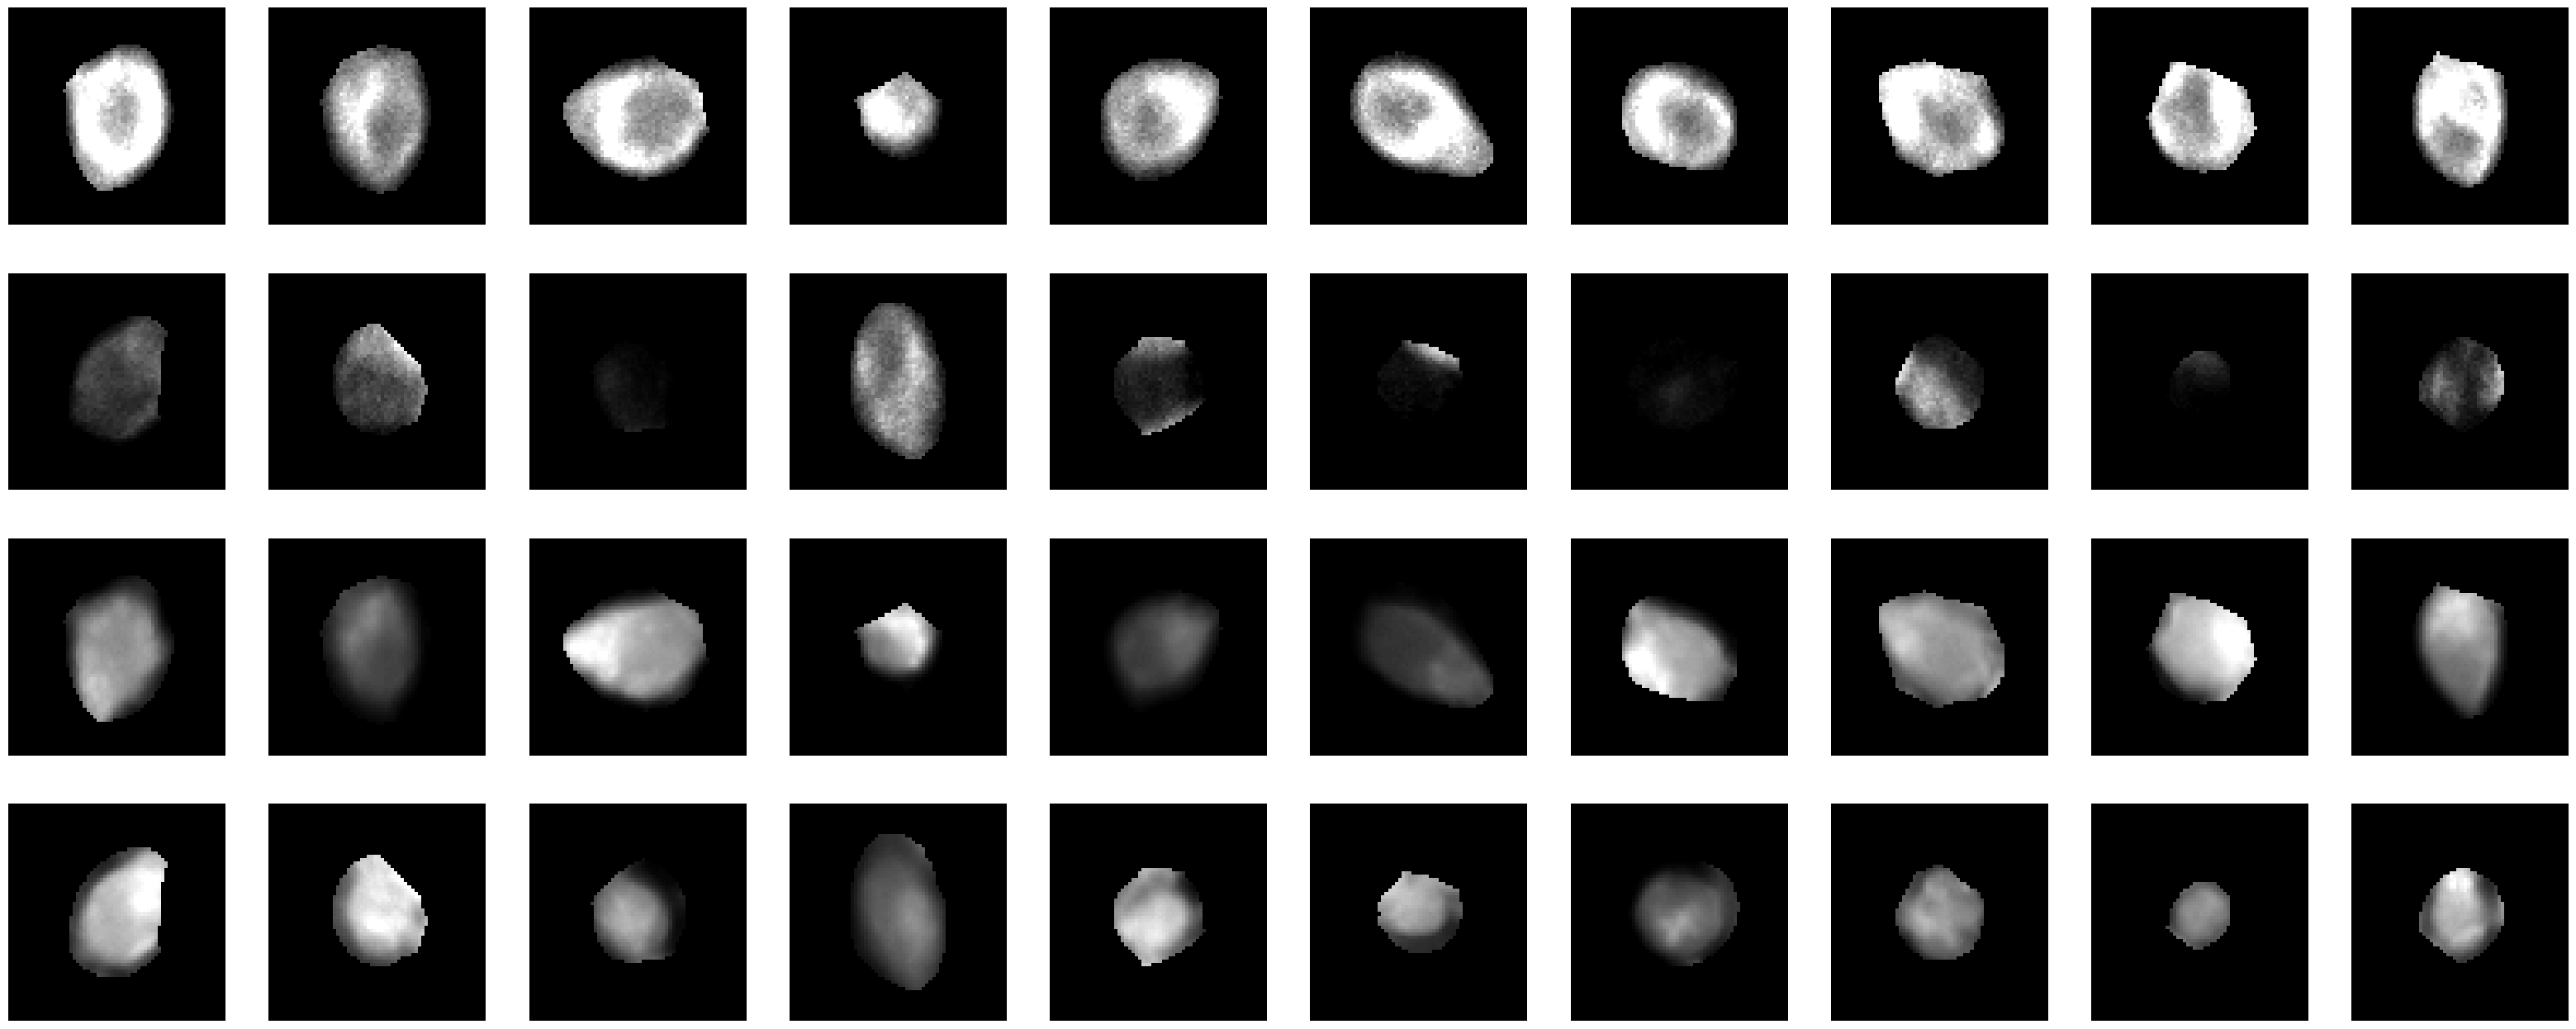

In [268]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(4,10, figsize = (40,16))

# define constants
feature_name = 'Intensity_MeanIntensity_RANGAP1'
MIN1 = 0; MAX1 =1; MIN2 = -2; MAX2 = -1;
n_cells = 10
seed = 12345
channel = 'RANGAP1'
ch = channels.index(channel)
gene = 'FAN1'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    
ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[2][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 200, cmap ='gray')
    axs[3][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 200, cmap = 'gray')
    axs[2][i].axis('off')
    axs[3][i].axis('off')
    

['94316_STD1_D10', '20340_STD1_D10', '94316_STD1_D10', '20340_STD1_D10'] ['82539_STD1_D10', '2850_STD2_D10', '82539_STD1_D10', '2850_STD2_D10']


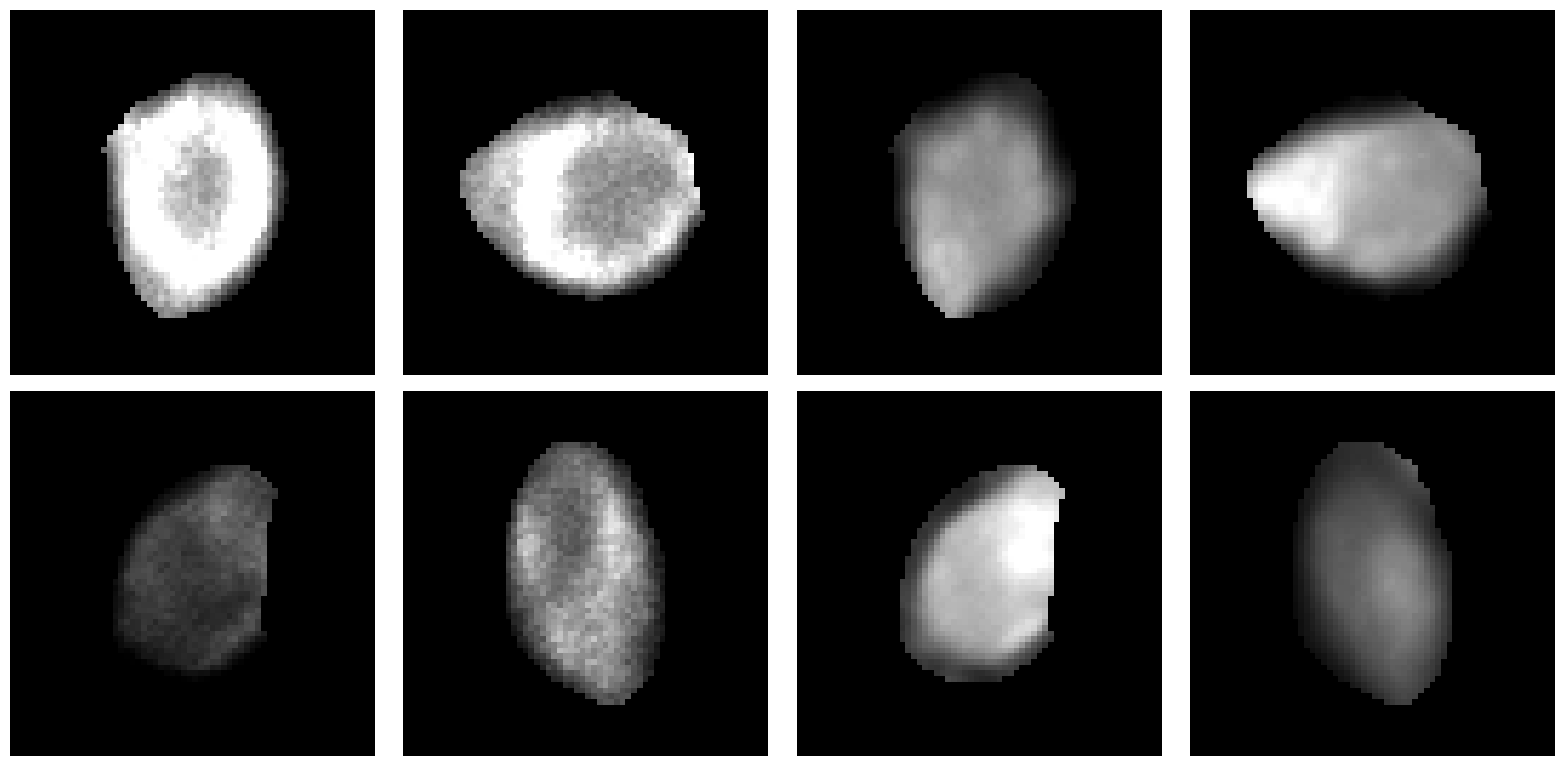

In [269]:
final_cells1 = [cells1[0]] + [cells1[2]] 
final_cells2 = [cells2[0]] + [cells2[3]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['RANGAP1','RANGAP1','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    if channels_to_plot[i] == 'ER':
        VMAX = 200
    else:
        VMAX = 150
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_FAN1_RANGAP1_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_FAN1_RANGAP1_Example.eps', format='eps',dpi=300)


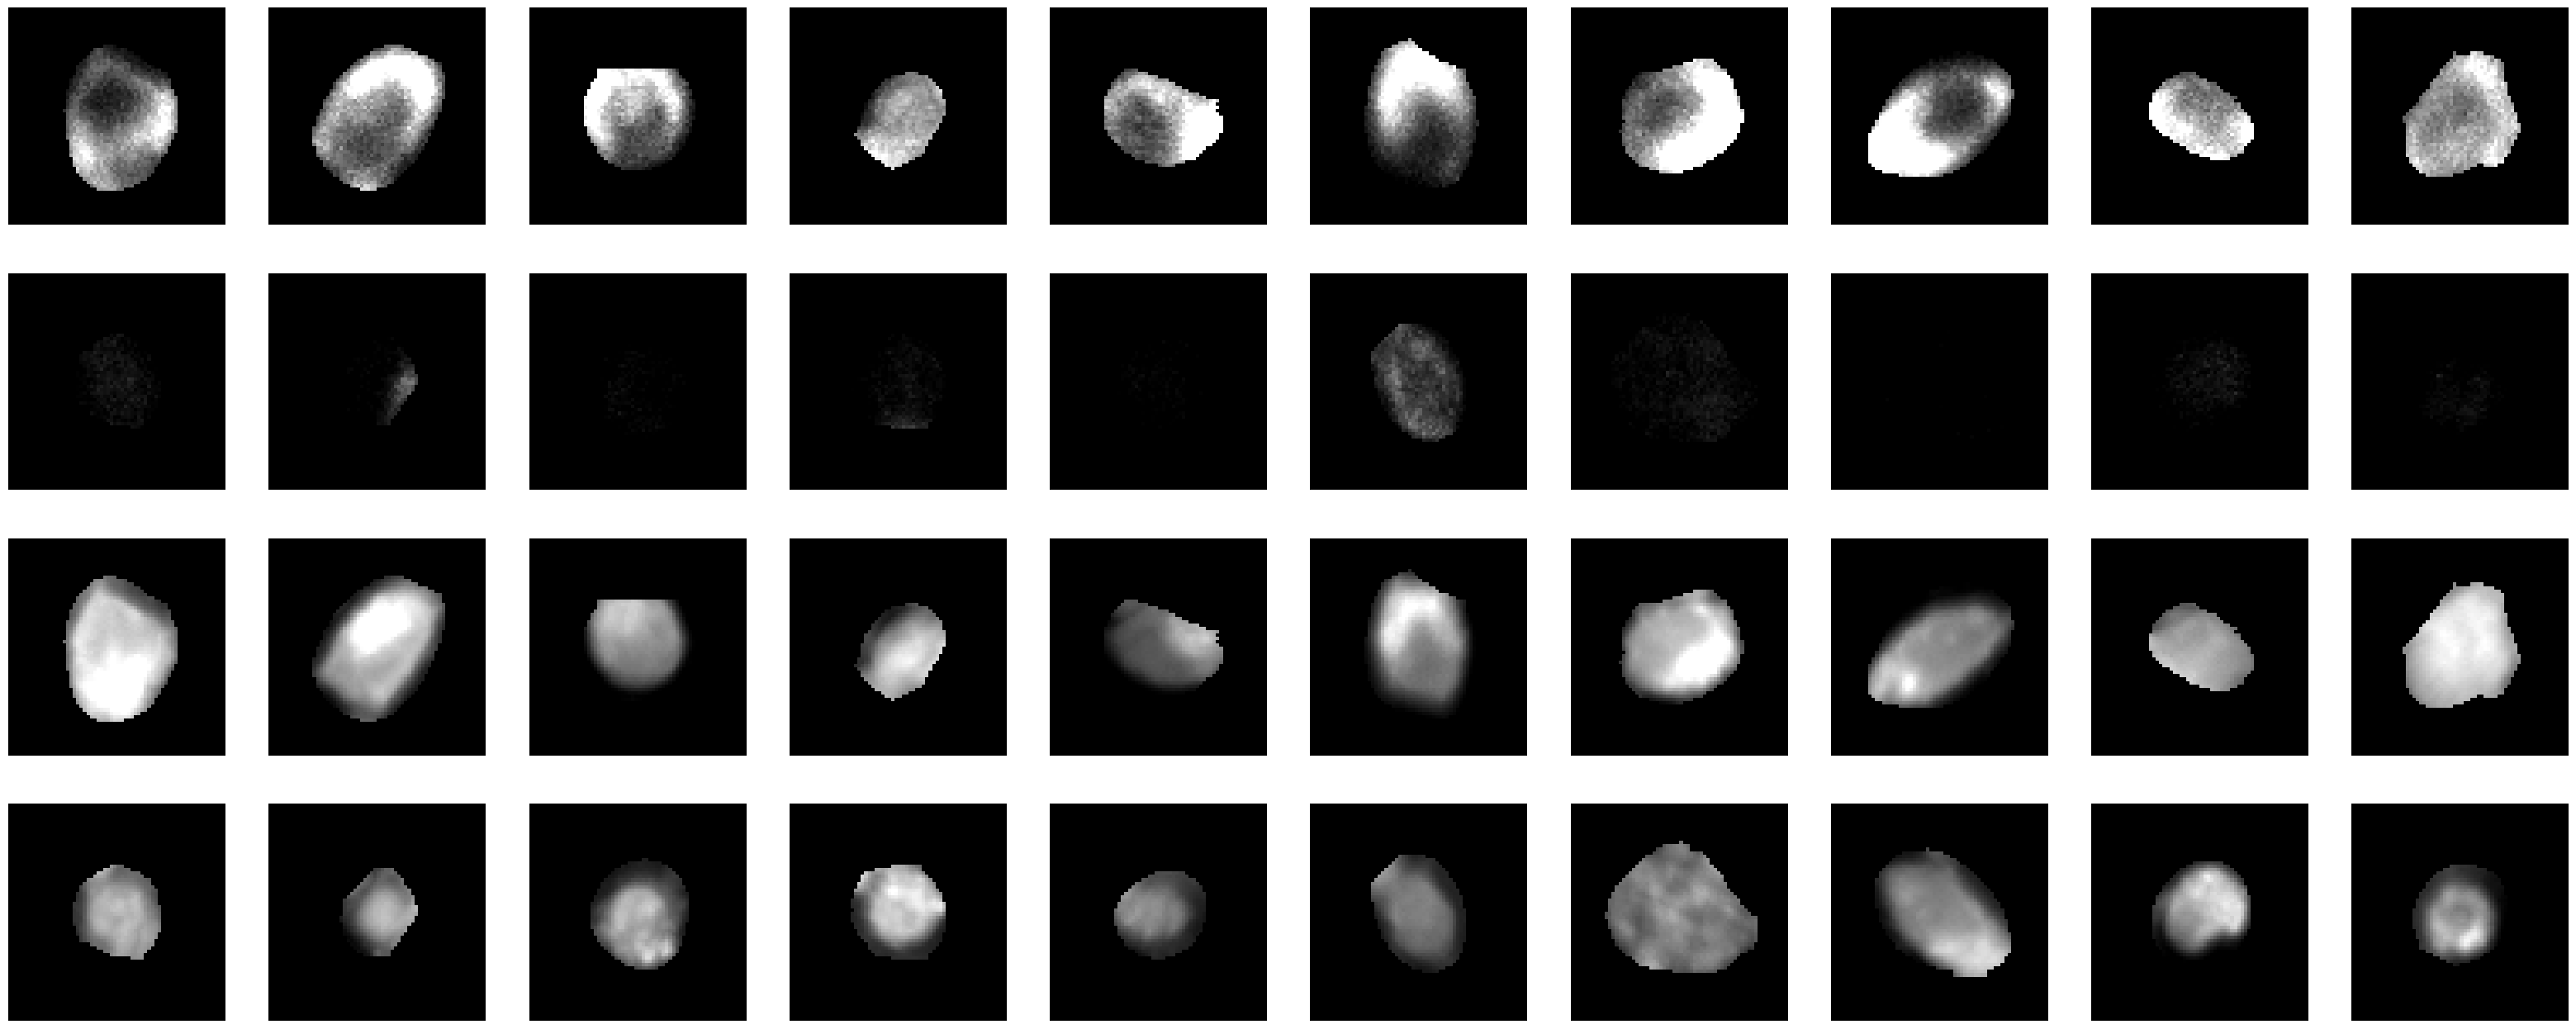

In [281]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(4,10, figsize = (40,16))

# define constants
feature_name = 'Intensity_MeanIntensity_G3BP1'
MIN1 = 1; MAX1 = 2; MIN2 = -2.5; MAX2 = -1.5;
n_cells = 10
seed = 123
channel = 'G3BP1'
ch = channels.index(channel)
gene = 'PPP2R2B'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    
ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[2][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 200, cmap ='gray')
    axs[3][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 200, cmap = 'gray')
    axs[2][i].axis('off')
    axs[3][i].axis('off')
    

['63790_STD2_D10', '5321_STD1_D10', '63790_STD2_D10', '5321_STD1_D10'] ['2564_STD2_D10', '65116_STD1_D10', '2564_STD2_D10', '65116_STD1_D10']


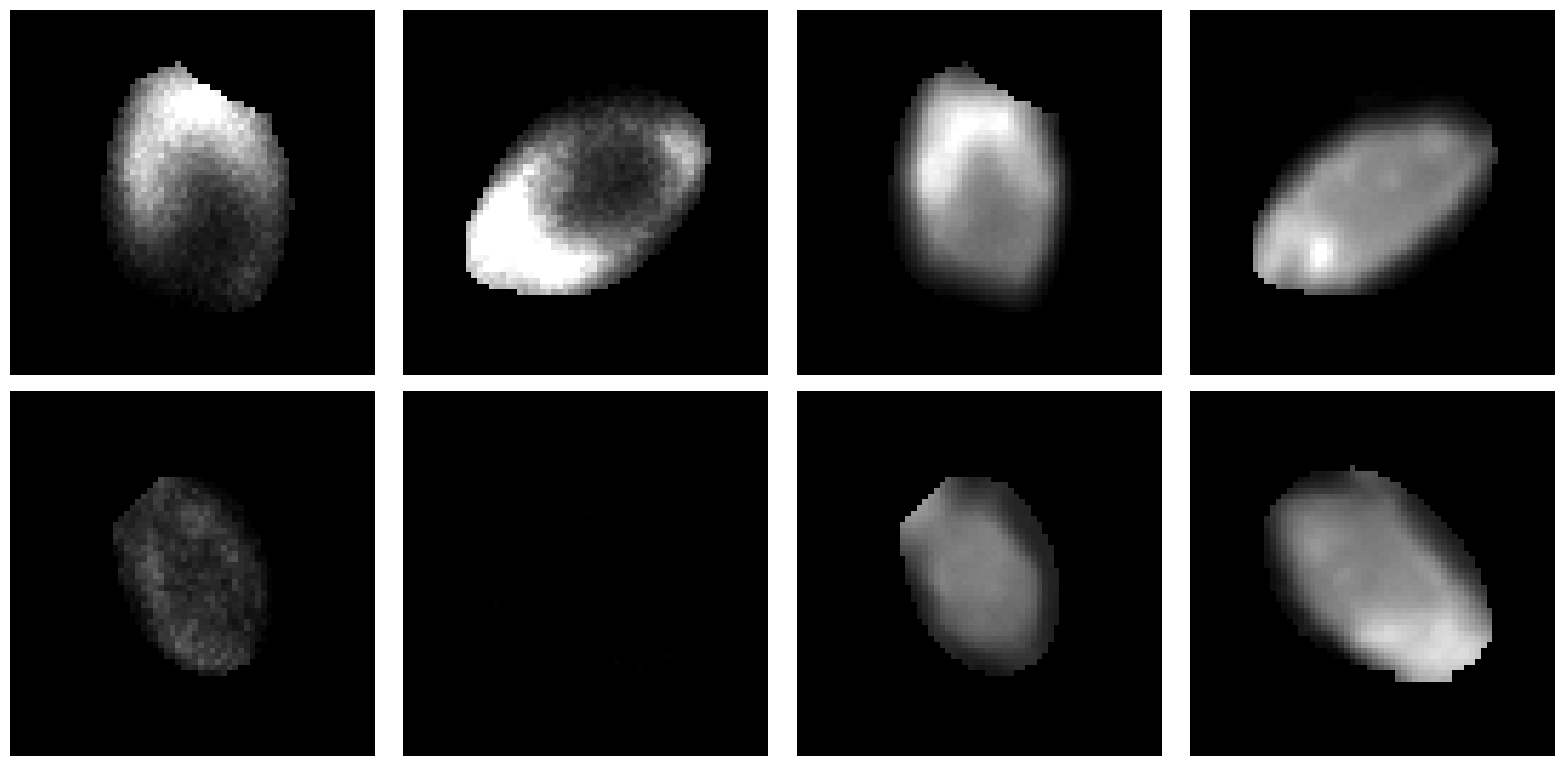

In [282]:
final_cells1 = [cells1[5]] + [cells1[7]] 
final_cells2 = [cells2[5]] + [cells2[7]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['G3BP1','G3BP1','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    if channels_to_plot[i] == 'ER':
        VMAX = 200
    else:
        VMAX = 200
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_G3BP1_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_G3BP1_Example.eps', format='eps',dpi=300)


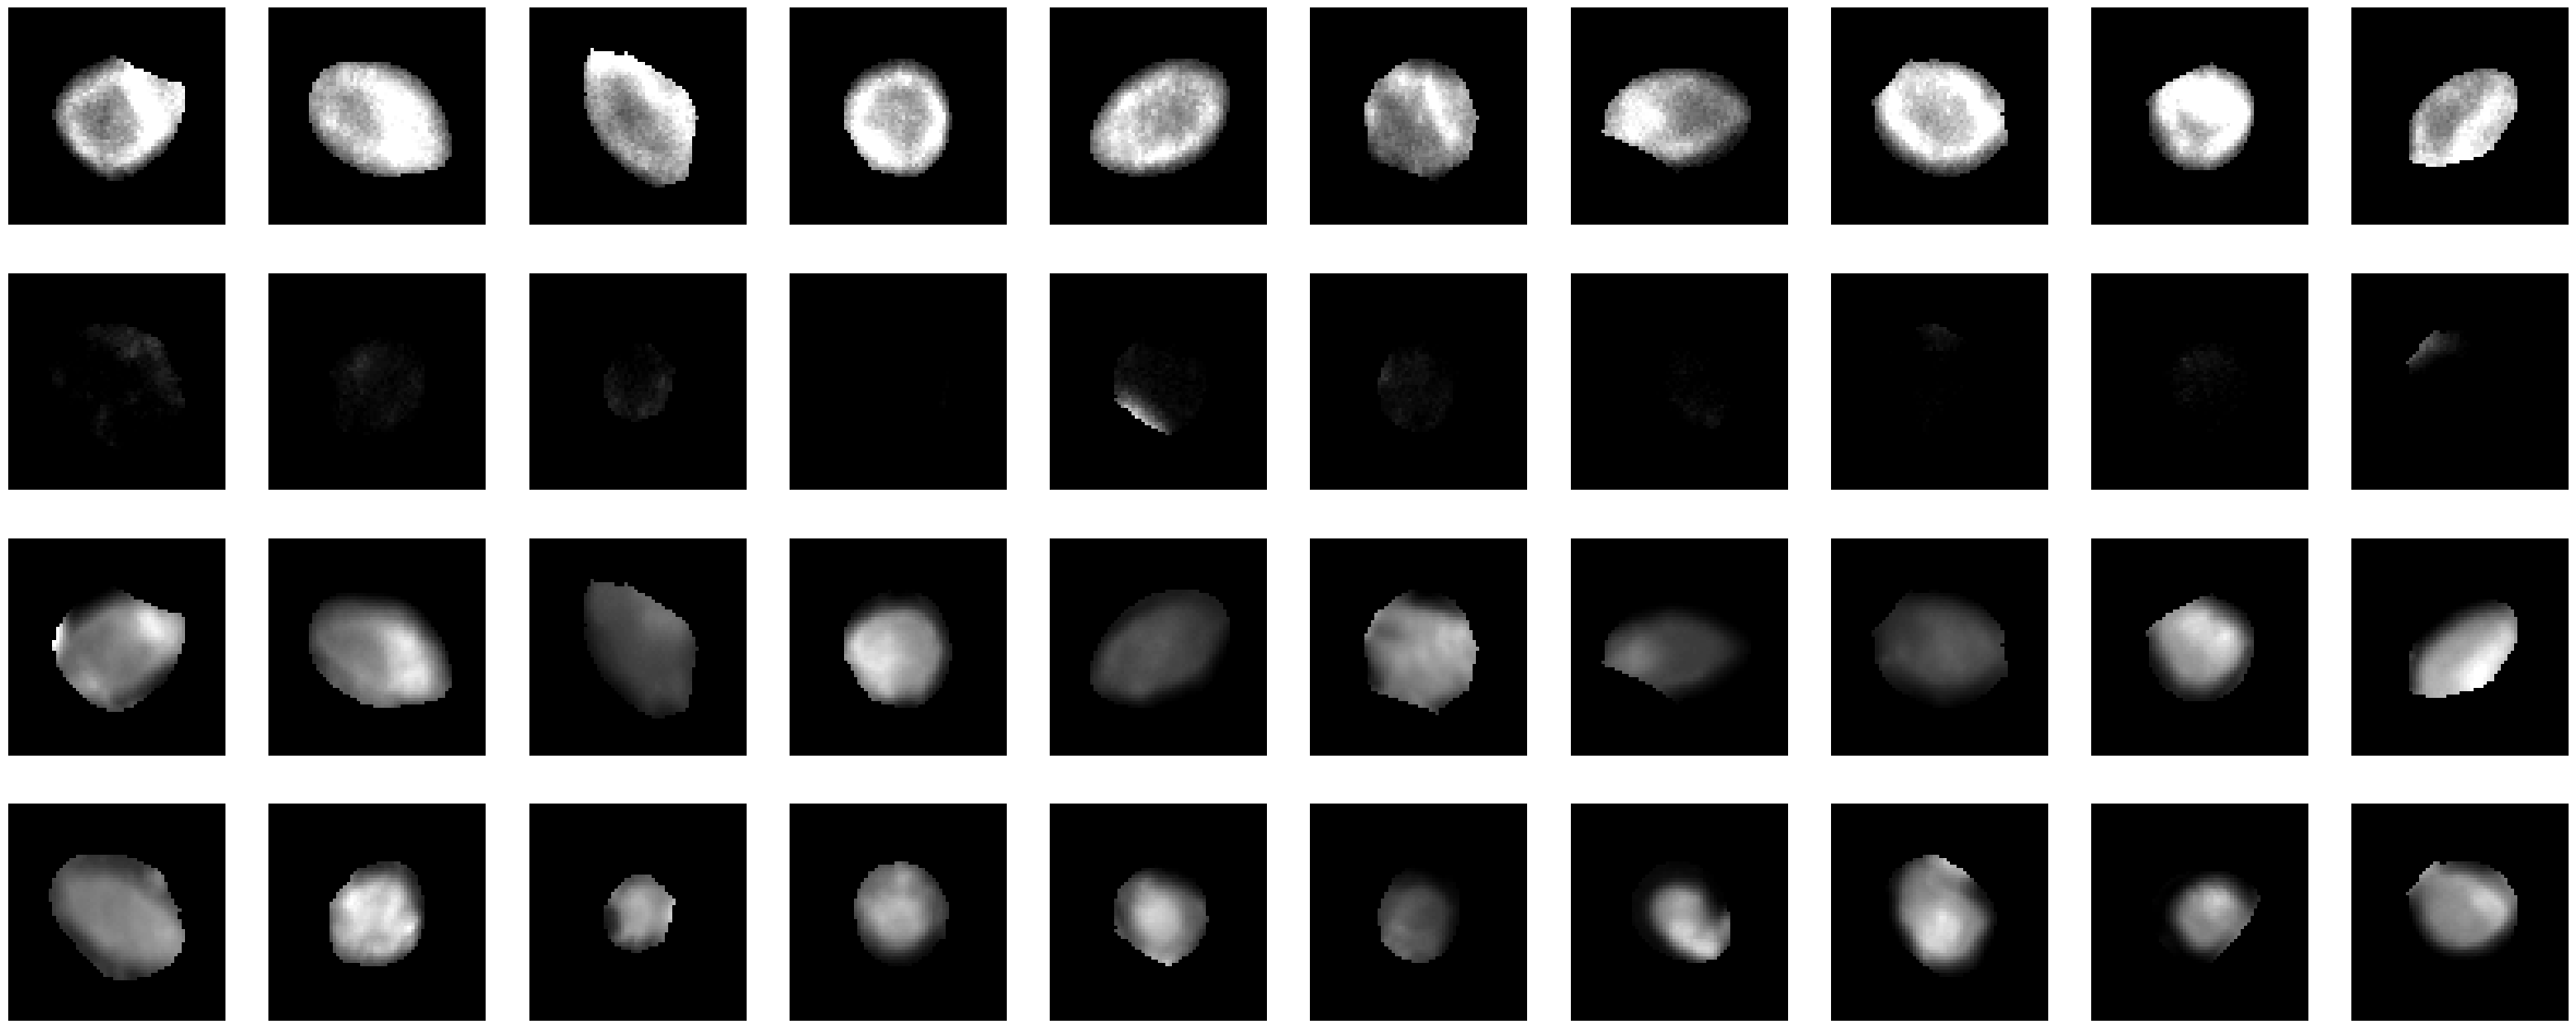

In [291]:
# plot selected features and genes with ER 
fig, axs = plt.subplots(4,10, figsize = (40,16))

# define constants
feature_name = 'Intensity_MeanIntensity_RANGAP1'
MIN1 = 0; MAX1 =1; MIN2 = -3; MAX2 = -2;
n_cells = 10
seed = 123
channel = 'RANGAP1'
ch = channels.index(channel)
gene = 'PPP2R2B'

grp1 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == 'non-target')]
grp2 = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')&(adata.obs.Gene == gene)]

grp1 = utils.subset_adata_by_feature_ranges(grp1, feature_name, MIN1, MAX1)
grp2 = utils.subset_adata_by_feature_ranges(grp2, feature_name, MIN2, MAX2)

cells1, cells2 = utils.get_cells(grp1, grp2, n_cells, seed=seed)
images1 = im_df.loc[cells1]
images2 = im_df.loc[cells2]
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 150,
                    cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 150, 
                     cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
    
ch = channels.index('ER')
# plot each cells
for i in range(len(cells1)):
    cell1 = cells1[i]
    cell2 = cells2[i]
    #axs[0][i].imshow(images1.loc[cell1].image[ch_id,...], vmin = 5, vmax = 255)
    #axs[1][i].imshow(images2.loc[cell2].image[ch_id,...], vmin=5, vmax = 255)
    axs[2][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, vmin = 5, vmax = 200, cmap ='gray')
    axs[3][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, vmin=5, vmax = 200, cmap = 'gray')
    axs[2][i].axis('off')
    axs[3][i].axis('off')
    

['30496_STD1_D10', '47426_STD2_D10', '30496_STD1_D10', '47426_STD2_D10'] ['39220_STD2_D10', '104902_STD1_D10', '39220_STD2_D10', '104902_STD1_D10']


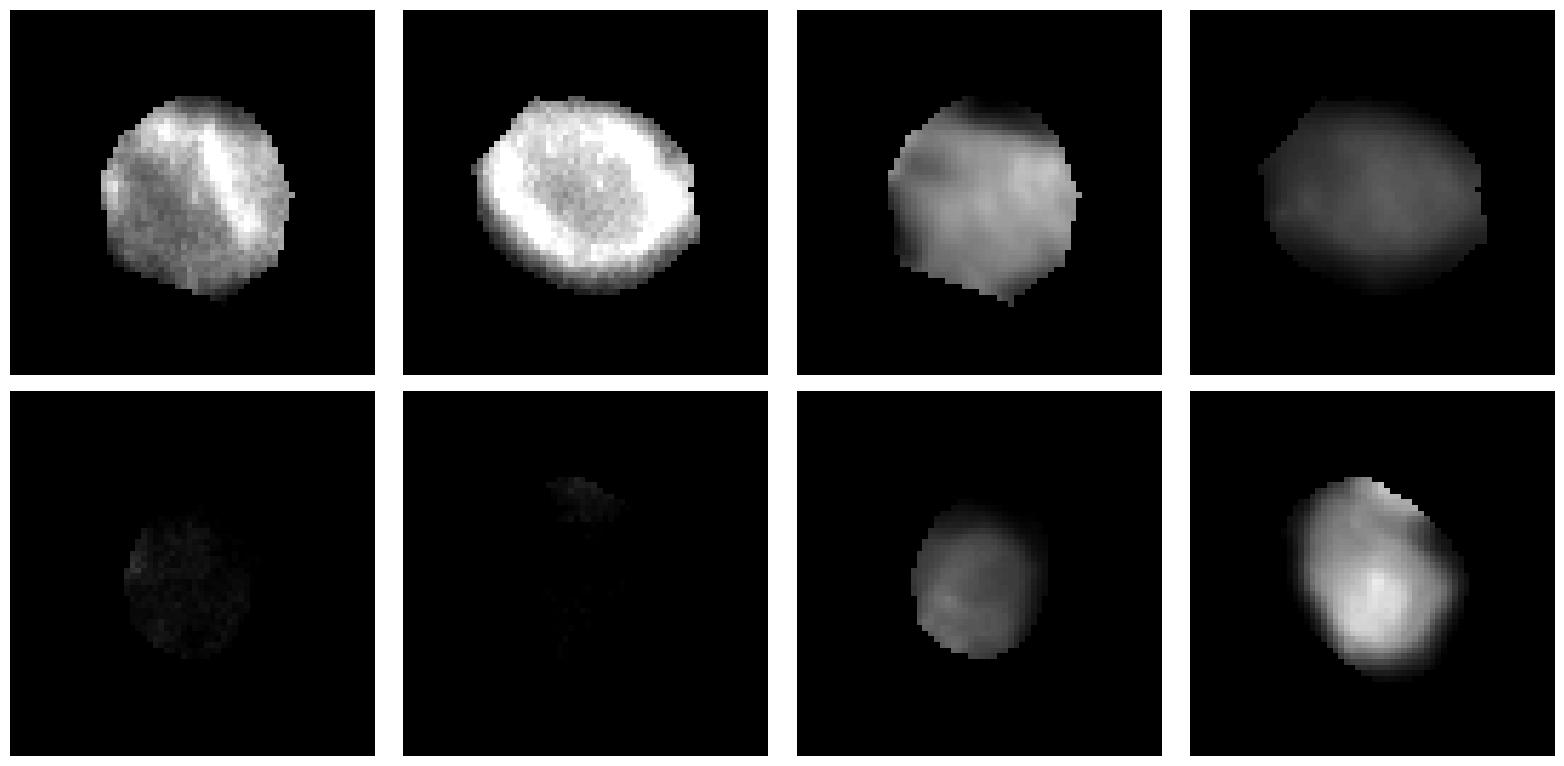

In [288]:
final_cells1 = [cells1[5]] + [cells1[7]] 
final_cells2 = [cells2[5]] + [cells2[7]]
final_cells1 *=2
final_cells2 *=2
print(final_cells1, final_cells2)
# plot 2 cells, 2 rows, 2 color
fig, axs = plt.subplots(2,4, figsize = (16,8))
channels_to_plot = ['RANGAP1','RANGAP1','ER','ER']
for i in range(4):
    ch = channels.index(channels_to_plot[i])
    cell1 = final_cells1[i]
    cell2 = final_cells2[i]
    if channels_to_plot[i] == 'ER':
        VMAX = 200
    else:
        VMAX = 150
    axs[0][i].imshow(images1.loc[cell1].image[ch,...]*images1.loc[cell1].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap ='gray')
    axs[1][i].imshow(images2.loc[cell2].image[ch,...]*images2.loc[cell2].soma_mask, 
                     vmin = 5, vmax = VMAX, cmap = 'gray')
    axs[0][i].axis('off')
    axs[1][i].axis('off')
plt.tight_layout()
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_RANGAP1_Example.png', format='png',dpi=300)
plt.savefig('../Figures_Fig4/D10_STD_PPP2R2B_RANGAP1_Example.eps', format='eps',dpi=300)


In [304]:
RESULT_DIR

'../Fig4_Results'

## all other genes - for Table SXX

In [303]:
with open(f'{RESULT_DIR}/ks_results_store', 'rb') as f:
    ks_results_store=pickle.load(f)
ks_results_store

{'D10_STD': {'ARPC3':                                     p_val      stat     p_adj  Median_Z  \
  AreaShape_CentralMoment_0_1      0.567321  0.037366  0.696403 -0.009757   
  AreaShape_CentralMoment_0_2      0.009754  0.078036  0.052826 -0.011974   
  AreaShape_CentralMoment_0_3        0.0725  0.061517  0.205782  0.081763   
  AreaShape_CentralMoment_1_0       0.13458  0.055442  0.303395 -0.112882   
  AreaShape_CentralMoment_1_1       0.12408  0.056277   0.28658 -0.000490   
  ...                                   ...       ...       ...       ...   
  Texture_Variance_pRPS6_3_03_256    0.3826  0.043214  0.549879 -0.445173   
  Texture_Variance_pRPS6_5_00_256  0.393417  0.042834  0.557209 -0.447145   
  Texture_Variance_pRPS6_5_01_256  0.451373  0.040898  0.605041 -0.440940   
  Texture_Variance_pRPS6_5_02_256  0.483816  0.039872  0.631755 -0.438514   
  Texture_Variance_pRPS6_5_03_256  0.381529  0.043252  0.549736 -0.447804   
  
                                     Mean_Z  R2_QQplo

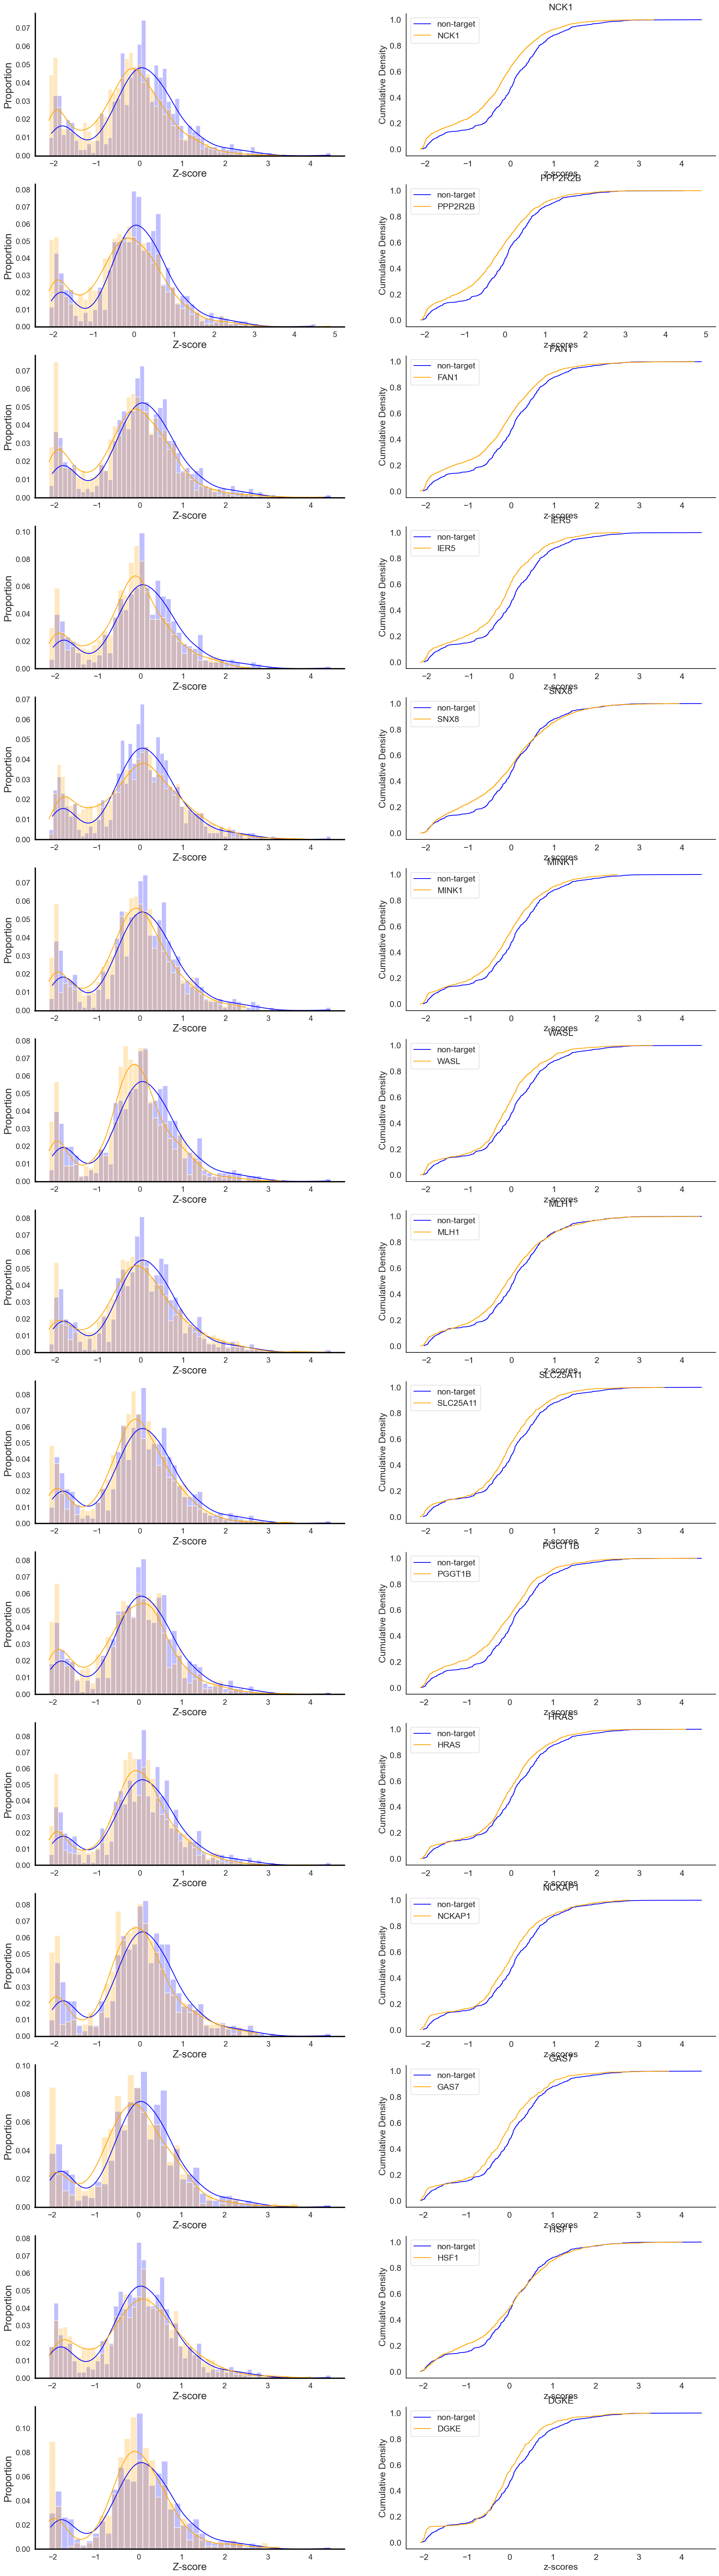

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [311]:
# plot for each channel;
feature = 'Intensity_MedianIntensity_NeuN'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[df.p_adj < 0.05]
genes = df.sort_values(by = '-log10(FDR)', ascending = False).index
N = len(genes)

data = adata[(adata.obs.Time == 'D10')&(adata.obs.Media == 'STD')]

fig, axs = plt.subplots(N,2, figsize = (24,6*N))

upper_lim = False; lower_lim = False

for i in range(len(genes)):
    gene = genes[i]
    data1 = data[data.obs.Gene == 'non-target', feature].X.flatten()
    data2 = data[data.obs.Gene == gene,feature].X.flatten()

    if upper_lim:
        data1 = data1[data1<np.quantile(data1, 0.99)]
        data2 = data2[data2<np.quantile(data2, 0.99)]
    elif lower_lim:
        data1 = data1[data1>np.quantile(data1, 0.01)]
        data2 = data2[data2>np.quantile(data2, 0.01)]
    
    # additional clippping for visualization;
    data1 = data1[data1<5]
    data2 = data2[data2<5]
    
    utils.diff_feature_distribution(data1, data2, 'non-target',gene, feature, axs[i][0])
    utils.plot_cdf(data1, data2, ax=axs[i][1], label1='non-target', label2=gene, 
             title=gene, xlabel='z-scores', ylabel='Cumulative Density')
plt.close()    

In [313]:
feature = 'Intensity_MedianIntensity_RANGAP1'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

p_val      stat     p_adj  Median_Z    Mean_Z R2_QQplot  \
SNX8          0.0  0.208889       0.0 -0.131656 -0.512693  0.664521   
NCK1          0.0  0.176481       0.0 -0.063491 -0.461566   0.70006   
PPP2R2B       0.0  0.187147       0.0 -0.115617 -0.485725  0.692619   
FAN1          0.0   0.17015       0.0 -0.018605 -0.433666  0.588744   
HSF1          0.0  0.150962       0.0  0.022971 -0.338258  0.773342   
MAP4K4        0.0  0.145229  0.000005  0.016905 -0.347165  0.771313   
MLH1     0.000034  0.115066  0.000183  0.006856 -0.260584  0.854492   
MINK1    0.000038  0.113619  0.000255  0.064547 -0.255573   0.83662   

        -log10(FDR)  
SNX8      15.910892  
NCK1      11.049872  
PPP2R2B     10.6519  
FAN1       9.528364  
HSF1        6.41653  
MAP4K4     5.310856  
MLH1       3.736513  
MINK1      3.594071

In [314]:
feature = 'Intensity_MedianIntensity_Golgin97'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

p_val      stat p_adj  Median_Z    Mean_Z R2_QQplot -log10(FDR)
NCK1       0.0  0.340844   0.0 -0.732656 -0.799145  -0.21686   44.552441
FAN1       0.0  0.301926   0.0 -0.729358 -0.740364 -0.196036   31.753036
SLC25A11   0.0    0.3162   0.0 -0.613847 -0.640419 -0.305864   29.684912
MINK1      0.0  0.298613   0.0 -0.613847 -0.671443 -0.084162   29.137146
PPP2R2B    0.0  0.293082   0.0 -0.673251 -0.722765  0.135924   27.879267
ARPC3      0.0  0.284917   0.0 -0.604168 -0.573514  0.130868   27.217188
HRAS       0.0  0.286965   0.0 -0.613847 -0.637395 -0.320478   27.167372
WASL       0.0  0.295665   0.0 -0.613847 -0.638018 -0.142707   26.930372
MLH1       0.0  0.282799   0.0 -0.613847 -0.643633  0.101183   25.755684
NCKAP1     0.0  0.310554   0.0 -0.613847 -0.659719 -0.434711   24.541294
IER5       0.0  0.293635   0.0 -0.613847 -0.679116 -0.164584   23.687889
GAS7       0.0   0.30717   0.0 -0.604168 -0.583456 -1.598108   15.264714
DGKE       0.0  0.289999   0.0 -0.541573 -0.529676  -0.20623   14.877891
RAPGEF2    0.0  0.224051   0.0 -0.495038 -0.501574  0.178513   11.984182

In [315]:
feature = 'Intensity_MedianIntensity_G3BP1'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

p_val      stat     p_adj  Median_Z    Mean_Z R2_QQplot  \
NCK1          0.0  0.194237       0.0 -0.431653 -0.514278  0.761899   
SNX8          0.0  0.165584       0.0 -0.224932 -0.300002  0.889528   
FAN1          0.0   0.17323       0.0 -0.337799 -0.481154  0.784068   
PPP2R2B       0.0  0.173201       0.0 -0.368698 -0.466937  0.798726   
MAP4K4        0.0  0.136772  0.000009 -0.250772 -0.328752  0.889337   
MINK1    0.000001  0.132518  0.000022 -0.214201 -0.345657  0.872502   
MLH1     0.000008  0.122216  0.000064 -0.198752 -0.280746  0.914343   
IER5      0.00022  0.112505  0.002249 -0.214201   -0.2744  0.918027   

        -log10(FDR)  
NCK1      13.483395  
SNX8      10.411119  
FAN1       9.859491  
PPP2R2B    9.272257  
MAP4K4     5.046031  
MINK1      4.655313  
MLH1       4.192949  
IER5       2.647982

In [316]:
feature = 'Intensity_MedianIntensity_NFKB'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

p_val      stat p_adj  Median_Z    Mean_Z R2_QQplot -log10(FDR)
NCK1       0.0  0.322158   0.0  -0.69621 -0.737142  0.293037   40.003731
PPP2R2B    0.0  0.309884   0.0 -0.678481 -0.710348  0.526145   31.359299
FAN1       0.0  0.288219   0.0 -0.678481 -0.705315  0.603531   28.890734
MLH1       0.0  0.290524   0.0 -0.592129 -0.628602  0.484627    26.99785
MINK1      0.0  0.254379   0.0 -0.550139 -0.601721  0.316495   20.722214
HRAS       0.0  0.243709   0.0 -0.505777 -0.492848  0.727198   19.114855
WASL       0.0  0.252086   0.0 -0.505777 -0.537596  0.310326   19.031136
IER5       0.0  0.251872   0.0 -0.550139 -0.591409  0.426787   16.931664
SLC25A11   0.0   0.24422   0.0 -0.505777 -0.498972  0.369389   16.850172
NCKAP1     0.0  0.253627   0.0 -0.550139 -0.546595  0.248282   15.872772
ARPC3      0.0  0.217551   0.0 -0.419425 -0.427227  0.736583   15.055731
DGKE       0.0  0.260795   0.0 -0.505777 -0.431416  0.535517   11.640037
RAPGEF2    0.0  0.200128   0.0 -0.404068 -0.385974  0.646176    9.566852
GAS7       0.0  0.247939   0.0 -0.477104 -0.403086 -0.181739    9.279899

In [317]:
feature = 'Intensity_MedianIntensity_NeuN'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

p_val      stat     p_adj  Median_Z    Mean_Z R2_QQplot -log10(FDR)
NCK1      0.0  0.173336       0.0 -0.239263 -0.337809   0.86706   10.706668
PPP2R2B   0.0   0.15482       0.0 -0.229623 -0.274344  0.928032    7.371933
FAN1      0.0  0.140211       0.0 -0.191368 -0.278053  0.919237    6.555862
IER5      0.0  0.161567  0.000001 -0.160683  -0.27663  0.874126    5.889496

In [318]:
feature = 'Intensity_MedianIntensity_TDP43'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

Empty DataFrame
Columns: [p_val, stat, p_adj, Median_Z, Mean_Z, R2_QQplot, -log10(FDR)]
Index: []

In [319]:
feature = 'Intensity_MedianIntensity_pRPS6'
genes = list(ks_results_store['D10_STD'].keys())
df = pd.DataFrame(index = genes, columns = ks_results_store['D10_STD'][genes[0]].columns)

for gene in genes:
    df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature]

# sort by stat
df = df[(df.p_adj < 0.05)&(df.Mean_Z < -0.25)]
df.sort_values(by = '-log10(FDR)', ascending = False)

p_val      stat p_adj  Median_Z    Mean_Z R2_QQplot -log10(FDR)
SNX8   0.0  0.195938   0.0 -0.554195 -0.308333  0.899208    14.15654
NCK1   0.0  0.183054   0.0 -0.581772  -0.28637    0.9102   11.964237

In [323]:
channels = ['Golgin97','NFKB','RANGAP1', 'G3BP1',
           'DNA','NeuN','pRPS6','TOM20','LAMP1','TDP43',
           'GM130','SYTO','ER','AGP']
cols = ['p_adj','stat','Mean_Z','-log10(FDR)']

# Define the output Excel file name
output_file = f"{RESULT_DIR}/Table_S3.xlsx"

# Create an Excel writer object
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    for ch in channels:
        feature = f'Intensity_MedianIntensity_{ch}'
        genes = list(ks_results_store['D10_STD'].keys())
        df = pd.DataFrame(index=genes, columns=cols)

        # Populate the dataframe
        for gene in genes:
            df.loc[gene] = ks_results_store['D10_STD'][gene].loc[feature, cols]

        # Sort by '-log10(FDR)'
        df = df.sort_values(by='-log10(FDR)', ascending=False)

        # Write to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=ch)

print(f"Excel file '{output_file}' has been saved with each channel in a separate sheet.")


Excel file '../Fig4_Results/Table_S3.xlsx' has been saved with each channel in a separate sheet.
